# Portfolio Optimization and Risk Analysis  

**Author:** Enrique Ruiz de Almirón Da Silva  
**Objective:** Build, optimize, and evaluate multi-asset portfolios using modern portfolio theory, Monte Carlo simulations, and factor/risk-based validation.
Portfolio Optimization and Performance Analysis
 1. Data loading and selection
 2. Log Returns 
 3. covariance matrix estimation 
 4. Portfolio Analytics Functions
 5. Risk-Free Rate Retrieval
 6. Portfolio Constraints and Mandates
 7. Portfolio Optimization — Constraints and Setup
 8. Tangency Portfolio Optimization & Metrics   (ongoing) ⚠️
 9. Benchmarking
 10. Portfolio Risk & Stress Testing
 11. Brinson attribution (ongoing) ⚠️
 12. Fama Frentch  (ongoing) ⚠️
 
> **⚠️ Disclaimer** 

>This notebook forms part of an **independent research project** on portfolio optimization and factor analysis. 
>The repository’s goal is to **document my learning process**, demonstrate my **ability to structure quantitative research**, and **track progress** as I refine both technical and conceptual understanding. 
> The work is currently in progress and may include **interpretation inaccuracies, data alignment issues, code inefficiencies, or inconsistencies** in presentation.  
> Its primary purpose is **educational and exploratory**, serving as a framework for continuous improvement rather than an operative derivable. 
> I am **gradually enhancing** the methodology, documentation, and clarity of insights as I deepen my understanding of quantitative finance and data modeling.

 
 > **Note on methodology**
>
> This notebook presents a *static* portfolio optimization framework based on Modern Portfolio Theory (Markowitz, 1952), aimed at demonstrating the end-to-end quantitative workflow — from data collection and risk estimation to portfolio construction, validation, and performance attribution.
>
> In institutional asset management, portfolio optimization is typically performed **on a rolling or walk-forward basis**, where weights are re-optimized periodically using data available up to each point in time.  
> However, implementing a full rolling optimization and backtesting process is beyond the scope of this initial version.
>
> Future iterations of this notebook will incorporate:
> - Rolling (walk-forward) re-optimization and out-of-sample testing,
> - Rebalancing frequency sensitivity analysis,
> - Transaction cost integration and turnover control.
>
> For the current version, the focus remains on understanding the mechanics, limitations, and validation of the *static mean-variance framework*, complemented with robust evaluation techniques (bootstrapping, stress testing, and factor attribution).


## Import the necesary libraries 

In [363]:
# yfinance: to fetch stock price data from Yahoo Finance
import yfinance as yf  

# pandas: to handle data tables (DataFrames)
import pandas as pd  

# datetime and timedelta: to manage and shift dates
from datetime import datetime, timedelta  

# numpy: for numerical operations (arrays, math, statistics)
import numpy as np  

# minimize: optimization function from SciPy (useful for portfolio optimization)
from scipy.optimize import minimize  

import os
import time
import shutil
import time, random
import warnings

## 1. Data Loading and Selection

### 1.1 Import and Dataset Overview

We work with **Adjusted Close** prices for a diversified set of ETFs across equities, factors, sectors, alternatives, and fixed income.  
Adjusted close prices incorporate dividends and stock splits, which ensures that returns reflect the *true total return performance* of each asset.

This selection avoids the underestimation of high-dividend assets and provides a consistent basis for performance comparison.



In [364]:
core_equity = ["SPY", "VTI", "IWM", "IEUR", "EEM", "EWJ"]
factors = ["MTUM", "QUAL", "VLUE", "USMV", "IWD", "IWF"]
sectors = ["XLF", "XLK", "XLE", "XLV", "XLY", "XLP", "XLRE", "XLU", "XLB"]
alternatives = ["GLD", "DBC", "VNQ"]
fixed_income = ["LQD", "HYG", "IEF", "TIP", "SHY"]
tickers = core_equity + factors + sectors + alternatives + fixed_income

### 1.2 Load Data from CSV

For efficiency and reproducibility, we use a pre-downloaded CSV file (`adj_close_prices.csv`) containing Adjusted Close prices.  
The dataset spans from **September 2015 to September 2025**, providing a 10-year horizon of daily observations.


In [365]:
start_date = "2015-09-21"
end_date = "2025-09-18"

In [366]:
csv_path = "adj_close_prices.csv"
adj_close_df = pd.read_csv(csv_path)

In [367]:
pd.read_csv(csv_path).head()

,Date,SPY,VTI,IWM,IEUR,EEM,EWJ,MTUM,QUAL,VLUE,...,XLU,XLB,GLD,DBC,VNQ,LQD,HYG,IEF,TIP,SHY
0,2015-09-21,27.018238,39.000584,31.769234,101.077438,166.011353,86.048447,62.989754,52.750824,47.507710,...,30.741070,34.323936,108.529999,13.265676,50.970932,81.786507,50.279533,85.835426,83.857544,70.839691
1,2015-09-22,26.514198,38.428028,30.784304,99.546127,163.856598,84.895546,62.273182,52.313927,46.615250,...,30.356808,33.686775,107.790001,13.187025,50.328426,82.140106,49.915718,86.262276,84.062447,70.881454
2,2015-09-23,26.090158,38.428028,30.651009,99.248573,163.594635,84.727234,62.352783,52.194008,46.546024,...,30.436554,32.967949,108.220001,13.082159,50.644192,82.090561,49.827744,86.165627,84.001701,70.856392
3,2015-09-24,25.978153,38.158600,30.643612,99.082314,163.003174,84.424255,61.883911,52.048378,46.399845,...,30.683060,32.878098,110.489998,13.160808,50.169193,82.104744,49.581318,86.294464,84.009285,70.898186
4,2015-09-25,25.922150,39.101627,30.799120,97.778244,162.960953,84.253387,61.517590,52.093979,46.415314,...,30.980312,32.837257,109.809998,13.239458,50.369892,81.857216,49.328999,86.068977,83.561615,70.864777


### 1.3 Convert Dates to Datetime and Set as Index

We convert the `"Date"` column to a `DatetimeIndex` to enable time-series operations such as rolling windows, resampling,  
and cumulative performance calculations. This step ensures proper alignment across all assets.


In [368]:
# Convert 'Date' column to datetime and set it as index
adj_close_df["Date"] = pd.to_datetime(adj_close_df["Date"], errors="coerce")
adj_close_df = adj_close_df.set_index("Date").sort_index()

# Sanity check: confirm that index is datetime type
print(type(adj_close_df.index))

# Preview dataset
adj_close_df.head()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,SPY,VTI,IWM,IEUR,EEM,EWJ,MTUM,QUAL,VLUE,USMV,...,XLU,XLB,GLD,DBC,VNQ,LQD,HYG,IEF,TIP,SHY
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-21,27.018238,39.000584,31.769234,101.077438,166.011353,86.048447,62.989754,52.750824,47.507710,33.385509,...,30.741070,34.323936,108.529999,13.265676,50.970932,81.786507,50.279533,85.835426,83.857544,70.839691
2015-09-22,26.514198,38.428028,30.784304,99.546127,163.856598,84.895546,62.273182,52.313927,46.615250,33.038269,...,30.356808,33.686775,107.790001,13.187025,50.328426,82.140106,49.915718,86.262276,84.062447,70.881454
2015-09-23,26.090158,38.428028,30.651009,99.248573,163.594635,84.727234,62.352783,52.194008,46.546024,33.104416,...,30.436554,32.967949,108.220001,13.082159,50.644192,82.090561,49.827744,86.165627,84.001701,70.856392
2015-09-24,25.978153,38.158600,30.643612,99.082314,163.003174,84.424255,61.883911,52.048378,46.399845,33.079617,...,30.683060,32.878098,110.489998,13.160808,50.169193,82.104744,49.581318,86.294464,84.009285,70.898186
2015-09-25,25.922150,39.101627,30.799120,97.778244,162.960953,84.253387,61.517590,52.093979,46.415314,33.089573,...,30.980312,32.837257,109.809998,13.239458,50.369892,81.857216,49.328999,86.068977,83.561615,70.864777


## 2. Logarithmic Returns

We compute **logarithmic returns** using the formula:
$$
r_t = \ln \left(\frac{P_t}{P_{t-1}}\right)
$$

Why start with log returns?

Log returns are commonly used in quantitative finance because:

- They are time-additive, so cumulative performance can be expressed as a simple sum.
- They correspond to continuously compounded returns, consistent with modern asset pricing models.
- They are approximately normally distributed, which simplifies covariance-based estimations.

However, the Markowitz portfolio optimization framework assumes linear aggregation of asset returns — a property that holds for arithmetic (simple) returns, not logarithmic ones.

To ensure both numerical stability and theoretical consistency, we:
- Compute log returns for clean, symmetric data,
- Then convert them to arithmetic returns before computing expected returns and covariances.

This hybrid approach preserves the advantages of log returns while keeping all optimization results economically correct.


In [369]:
# Calculate log returns for each asset
# Step 1: compute log returns (for numerical stability)
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

log_returns = log_returns.dropna()

# Step 2: convert log → arithmetic (for portfolio math)
returns = np.exp(log_returns) - 1

# Remove rows with NaN values (the very first row will always be NaN)
returns = returns.dropna()

# Display first few rows
returns.head()

,SPY,VTI,IWM,IEUR,EEM,EWJ,MTUM,QUAL,VLUE,USMV,...,XLU,XLB,GLD,DBC,VNQ,LQD,HYG,IEF,TIP,SHY
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-09,0.003630,0.002486,0.000227,0.001991,0.000597,0.001350,0.005406,0.000792,-0.001571,0.001952,...,-0.004773,-0.000453,0.015851,0.004461,-0.001643,0.000431,0.000118,0.000558,-0.002778,0.000000
2015-10-12,-0.007512,0.001653,-0.003622,-0.001469,0.000943,0.000193,0.003820,-0.001108,0.000787,0.003164,...,0.008906,-0.008607,0.003969,-0.015863,0.007090,0.004046,-0.001880,0.003351,0.001797,-0.000235
2015-10-13,-0.016260,-0.010726,-0.010907,-0.013672,-0.006302,-0.007319,-0.005638,-0.007292,-0.004559,-0.004368,...,-0.002264,-0.003884,0.004941,-0.006447,-0.007794,-0.000772,-0.002354,0.000927,-0.000538,0.000353
2015-10-14,0.007695,-0.011676,0.003446,-0.009825,-0.004794,-0.005141,-0.007938,-0.006068,-0.003948,-0.006824,...,-0.000227,0.008027,0.017432,0.002596,-0.007475,0.003947,-0.000708,0.005468,0.003410,0.001412
2015-10-15,0.024321,0.025317,0.014652,0.023921,0.015354,0.015113,0.013859,0.015264,0.011258,0.010797,...,0.014749,0.002730,-0.004569,-0.002589,0.013658,-0.000427,0.002362,-0.003411,-0.001878,-0.000588


### 2.2 Sanity Check

We now have a clean time series of daily log returns for all selected ETFs.  
Each column represents one asset, and each row corresponds to a trading day.



In [370]:
# Check dimensions of the returns matrix
returns.shape

(2499, 29)

## 3. Covariance Matrix Estimation

The covariance matrix captures how asset returns move together — it’s the cornerstone of modern portfolio theory (Markowitz, 1952).  
Each element $$\sigma_{ij}$$ represents the co-movement between asset *i* and asset *j*.

Since our log returns are **daily**, we annualize the covariance matrix by multiplying by 252 (the approximate number of trading days in a year).  
This allows portfolio risk (volatility) to be expressed in annualized terms, consistent with annualized expected returns.


In [371]:
# --- Covariance Matrix (Annualized) ---
# .cov() returns the daily covariance between each pair of assets.
# Multiplying by 252 annualizes the values (since volatility scales with sqrt(T), variance with T).
# Compute statistics with Pandas for readability
sigma = returns.cov() * 252
mu = returns.mean() * 252
# Sanity check: dimensions should equal number of assets
print("Covariance matrix shape:", sigma.shape)
sigma.head()

Covariance matrix shape: (29, 29)


,SPY,VTI,IWM,IEUR,EEM,EWJ,MTUM,QUAL,VLUE,USMV,...,XLU,XLB,GLD,DBC,VNQ,LQD,HYG,IEF,TIP,SHY
SPY,0.041878,0.024767,0.030638,0.032715,0.027759,0.028600,0.029022,0.027301,0.029020,0.019307,...,0.014971,0.030138,0.005113,0.014168,0.023854,0.004581,0.011511,-0.001382,0.000929,-0.000104
VTI,0.024767,0.029941,0.024597,0.027578,0.023212,0.023741,0.023559,0.023002,0.024479,0.016736,...,0.013358,0.024312,0.002833,0.009273,0.020177,0.003881,0.009088,-0.000717,0.000833,-0.000012
IWM,0.030638,0.024597,0.035174,0.033075,0.027715,0.028463,0.027208,0.027451,0.029881,0.020685,...,0.017038,0.031090,0.003820,0.012172,0.025759,0.005071,0.011707,-0.001276,0.001180,-0.000086
IEUR,0.032715,0.027578,0.033075,0.053043,0.036144,0.038188,0.036244,0.035764,0.040750,0.026051,...,0.020520,0.039446,0.001474,0.014204,0.035097,0.005563,0.014398,-0.001947,0.001067,-0.000213
EEM,0.027759,0.023212,0.027715,0.036144,0.032696,0.033220,0.033621,0.032451,0.032578,0.023990,...,0.019489,0.031725,0.001249,0.011074,0.027715,0.004598,0.011971,-0.001780,0.000539,-0.000218


In [372]:
# Convert to NumPy for optimization math
cov_matrix = sigma.values
mu = mu.values

# 📘 Why Convert from Pandas to NumPy?

Although both Pandas DataFrames and NumPy arrays can represent tabular data, they serve different purposes in a quantitative workflow.

We first compute statistics (mean returns and covariance) using Pandas, because it provides labeled, human-readable outputs that make it easy to inspect and verify results.
However, optimization routines and matrix algebra operations in NumPy and SciPy require pure numerical arrays — they operate faster and avoid potential index misalignment that can occur with labeled DataFrames.

Therefore, before optimization, we convert the objects to NumPy arrays:
This ensures:

- Numerical precision and speed in matrix operations (@, np.linalg, minimize)
- Avoidance of index alignment errors when multiplying or transposing
- Consistency with mathematical notation used in portfolio theory (Σ, μ, w as vectors/matrices)

In summary:

Compute with Pandas for clarity, optimize with NumPy for accuracy.

## 4. Portfolio Analytics Functions

We define the key portfolio functions used in optimization:

- **Expected Return:** the weighted average of annualized mean returns.  
- **Standard Deviation:** portfolio volatility derived from the covariance matrix.  
- **Sharpe Ratio:** excess return per unit of risk, relative to the risk-free rate. (risk-adjusted performance).
- **Negative Sharpe:** used as an objective function for numerical minimization.

$$(E[R_p] - R_f) / σ_p $$ 

> All inputs are expressed in *annualized* terms for consistency across metrics.


In [373]:
# ========= 2. Portfolio Functions =========

def expected_return(weights, mu):
    return float(weights @ mu)   # equivalent to np.sum(weights * mu)

def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def sharpe_ratio(weights, mu, cov_matrix, rf):
    er = expected_return(weights, mu)
    vol = standard_deviation(weights, cov_matrix)
    return (er - rf) / vol

def neg_sharpe(weights, mu, cov_matrix, rf):
    return -sharpe_ratio(weights, mu, cov_matrix, rf)


## 5. Risk-Free Rate Retrieval

To compute the Sharpe ratio, we need a reference risk-free rate.  
We use the **10-Year US Treasury Yield (IRLTLT01DEM156N)** from the FRED API as a proxy for long-term, risk-free returns.

The yield is converted from percentage to decimal format.


In [374]:
from fredapi import Fred

fred = Fred(api_key="7735cc881c957a302901c94bd79919c8")
ten_year_bund = fred.get_series('IRLTLT01DEM156N') / 100
rf = ten_year_bund.iloc[-1]
print("Risk-free rate (Bund 10Y):", rf)


Risk-free rate (Bund 10Y): 0.026933333333333302


alternatively use 0.25 

In [375]:
#risk_free_rate = 0.025

## 6. Portfolio Constraints and Mandates

In asset management, portfolio constraints reflect **investment mandates** — e.g., minimum allocations to equities or limits on alternatives.

We define category-level constraints (core equity, factors, sectors, etc.)  
to ensure the optimization respects realistic asset allocation guidelines.


In [376]:
# --- Asset Class Mandates (stylized AM-style limits) ---
mandates = {
    "core_equity": {"tickers": ["SPY", "VTI", "IWM", "IEUR", "EEM", "EWJ"], "min": 0.40, "max": 0.60},
    "factors": {"tickers": ["MTUM", "QUAL", "VLUE", "USMV", "IWD", "IWF"], "min": 0.10, "max": 0.25},
    "sectors": {"tickers": ["XLF", "XLK", "XLE", "XLV", "XLY", "XLP", "XLRE", "XLU", "XLB"], "min": 0.00, "max": 0.25},
    "fixed_income": {"tickers": ["LQD", "HYG", "IEF", "TIP", "SHY"], "min": 0.20, "max": 0.40},
    "alternatives": {"tickers": ["GLD", "DBC", "VNQ"], "min": 0.00, "max": 0.10}
}


## 7. Portfolio Optimization — Constraints and Setup

This section prepares all the components required for the **portfolio optimization problem**.

We:
1. Create *binary masks* to map each ETF to its corresponding asset class (e.g., Core Equity, Factors, Fixed Income).  
2. Define **constraints** — both total (∑w = 1) and group-level min/max limits.  
3. Define **individual bounds** (max exposure per asset).  
4. Initialize weights realistically based on mandate midpoints.

This approach mirrors institutional asset management, where optimization is subject to *investment mandates* and diversification limits.


In [377]:
# --- Flatten the universe in correct order ---
tickers = sum([mandates[g]["tickers"] for g in mandates], [])

# --- Create binary masks for each asset group ---
def create_masks(tickers, mandates):
    masks = {}
    for name, info in mandates.items():
        m = np.zeros(len(tickers))
        for t in info["tickers"]:
            if t in tickers:
                m[tickers.index(t)] = 1.0
        masks[name] = m
    return masks

masks = create_masks(tickers, mandates)

## 7.2 Define Portfolio Constraints and Bounds

We now define the **optimization constraints**:
1. **Full investment** → weights must sum to 1.  
2. **Group-level mandates** → enforce min/max allocation per asset class (e.g., 40–60% core equity).  
3. **Individual asset bounds** → cap position size to avoid overconcentration.

All constraints are expressed as functions of the weight vector `w` for compatibility with `scipy.optimize.minimize()`.


In [378]:
# --- Sum-to-one constraint ---
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]

# --- Group-level constraints (min/max per mandate) ---
for name, info in mandates.items():
    m = masks[name]
    mn, mx = info["min"], info["max"]

    # Lower bound constraint: np.dot(m, w) >= mn
    constraints.append({
        'type': 'ineq',
        'fun': lambda w, m=m, mn=mn: np.dot(m, w) - mn
    })

    # Upper bound constraint: np.dot(m, w) <= mx
    constraints.append({
        'type': 'ineq',
        'fun': lambda w, m=m, mx=mx: mx - np.dot(m, w)
    })

# --- Individual asset bounds ---
# These avoid excessive concentration in a single ETF.
# For example: (0%, 15%) means each ETF can represent at most 15% of total portfolio value.
bounds = [(0.00, 0.15) for _ in tickers]

### 🧠 Conceptual Note

- The `'eq'` constraint ensures **budget balance** (100% invested).
- The `'ineq'` constraints express **mandate compliance**.
- Bounds prevent extreme allocations and improve numerical stability.
- This structure mirrors how *portfolio managers* operate within mandate rules.


## 7.3 Initialize Weights Realistically

Rather than starting with equal weights,  
we initialize allocations near the midpoint of each mandate’s range (e.g., 50% core equity if range is 40–60%).

This produces:
- Faster convergence for the optimizer.
- A more realistic starting point, similar to an actual multi-asset allocation.


In [379]:
# --- Initialize weights centered on mandate midpoints ---
initial_weights = np.zeros(len(tickers))

for name, info in mandates.items():
    group_tickers = info["tickers"]
    mid = (info["min"] + info["max"]) / 2.0  # midpoint allocation per group
    if len(group_tickers) > 0:
        w_each = mid / len(group_tickers)
        for t in group_tickers:
            if t in tickers:
                initial_weights[tickers.index(t)] = w_each

# Normalize (just in case of rounding errors)
initial_weights = initial_weights / initial_weights.sum()


### ✅ Why This Matters

- Institutional portfolios often **start from target weights**, not random ones.
- Using the midpoint improves **numerical stability** and reflects **practical realism**.
- The normalization ensures the weights sum to exactly 1 even with floating-point rounding.


## 7.4 Sanity Check — Dimensional and Scaling Consistency

Before running the optimization routine, it’s essential to verify that all inputs are dimensionally consistent and correctly scaled.
Since the portfolio optimization will now operate directly on annualized statistics (mean vector and covariance matrix), we must ensure that all objects have coherent shapes and types.

This step prevents silent numerical errors (e.g., shape mismatches, Series-to-array issues) that often arise when switching between Pandas and NumPy objects.

Key checks performed:

- The number of tickers, mean returns (μ), covariance matrix (Σ), and weight vectors are all dimensionally aligned.

- The covariance matrix is square and corresponds to the same number of assets as μ.

- The risk-free rate is a valid scalar.

- The scaling of expected returns and volatilities is realistic (sanity range: 5–15% mean returns, 10–30% volatilities).

- Optional: The covariance matrix is positive semi-definite (required for valid variance computations).

In [380]:
# === Sanity Check: Dimensional and Scaling Consistency ===
import numpy as np

print("✅ Number of tickers:", len(tickers))
print("✅ mu (annualized mean returns) shape:", mu.shape, "| type:", type(mu))
print("✅ cov_matrix (NumPy covariance matrix) shape:", cov_matrix.shape, "| type:", type(cov_matrix))
print("✅ sigma (Pandas covariance matrix) shape:", sigma.shape, "| type:", type(sigma))
print("✅ Initial weights shape:", initial_weights.shape)
print("✅ Bounds length:", len(bounds))
print("✅ Risk-free rate:", rf)

# --- Additional consistency checks ---
assert mu.shape[0] == cov_matrix.shape[0], "❌ mu and cov_matrix dimension mismatch"
assert cov_matrix.shape[0] == cov_matrix.shape[1], "❌ cov_matrix must be square"
assert len(initial_weights) == len(mu), "❌ initial weights and mu mismatch"
assert isinstance(rf, (float, int)), "❌ risk_free_rate must be a scalar"

# --- Optional: scaling sanity check ---
print("\n--- Scaling Sanity ---")
avg_return = np.mean(mu)
avg_vol = np.mean(np.sqrt(np.diag(cov_matrix)))
print(f"Average annual return (μ): {avg_return:.4f}")
print(f"Average annual volatility (√diag Σ): {avg_vol:.4f}")
print(f"Average Sharpe proxy (μ/σ): {avg_return/avg_vol:.2f}")

# --- Optional: check covariance matrix validity ---
eigvals = np.real(np.linalg.eigvals(cov_matrix))
min_eig = np.min(eigvals)

if min_eig >= -1e-8:
    print("✅ Covariance matrix is positive semi-definite")
else:
    print(f"⚠️ Covariance matrix not PSD (min eigenvalue = {min_eig:.2e}) — check data or outliers")


✅ Number of tickers: 29
✅ mu (annualized mean returns) shape: (29,) | type: <class 'numpy.ndarray'>
✅ cov_matrix (NumPy covariance matrix) shape: (29, 29) | type: <class 'numpy.ndarray'>
✅ sigma (Pandas covariance matrix) shape: (29, 29) | type: <class 'pandas.core.frame.DataFrame'>
✅ Initial weights shape: (29,)
✅ Bounds length: 29
✅ Risk-free rate: 0.026933333333333302

--- Scaling Sanity ---
Average annual return (μ): 0.1056
Average annual volatility (√diag Σ): 0.1735
Average Sharpe proxy (μ/σ): 0.61
✅ Covariance matrix is positive semi-definite


## 7.5 Optimization Execution — Maximizing the Sharpe Ratio

We now perform the optimization using **SLSQP**  
(Sequential Least Squares Quadratic Programming), a method well-suited for smooth problems with both equality and inequality constraints.

### Objective
We minimize the **negative Sharpe ratio** (`neg_sharpe`) 
which is mathematically equivalent to maximizing the Sharpe ratio:

$$
\max_w \frac{E[R_p] - R_f}{\sigma_p} \quad \Leftrightarrow \quad \min_w -\frac{E[R_p] - R_f}{\sigma_p}
$$

### Why SLSQP?
- It handles *nonlinear objectives* and *linear constraints* simultaneously.  
- It supports **bounds**, **equality**, and **inequality** conditions — ideal for realistic portfolios.  
- It provides smooth convergence and interpretable diagnostics (`success`, `message`, `nfev`, etc.).


### ⚠️ About the SLSQP "Values in x were outside bounds" Warning

This warning appears when, during intermediate iterations, 
some weights temporarily exceed the defined bounds due to numerical rounding.
SLSQP automatically projects them back into the feasible region.

It **does not indicate a violation** of constraints or an optimization error — 
it’s purely informational and safe to ignore in well-behaved problems.


In [381]:
# --- Suppress known warning (non-critical from SLSQP) ---
warnings.filterwarnings("ignore", message="Values in x were outside bounds")

# --- Perform optimization ---
optimized_results = minimize(
    neg_sharpe,                               # objective function (negative Sharpe)
    initial_weights,                          # starting point
    args=(mu, cov_matrix, rf),                # additional parameters
    method='SLSQP',                           # optimization method
    constraints=constraints,                  # equality + inequality constraints
    bounds=bounds)                            # individual asset limits

### 🧠 Key Notes
- `args=` passes the extra parameters to the objective function.  
- The optimizer adjusts weights iteratively to minimize the output of `neg_sharpe()`.  
- Under the hood, `SLSQP` approximates the gradient numerically using finite differences.


## 7.6 Optimization Diagnostics

Always check the optimization report to verify:
- **Convergence status** (`success`)
- **Diagnostic message** (`message`)
- **Sum of weights** (should equal 1)
- **Objective value** (the negative Sharpe ratio at optimum)

If convergence fails, common issues include:
- Tight or conflicting constraints
- Poor initialization
- Numerical instability from near-singular covariance matrices


In [382]:
print("✅ Optimization successful:", optimized_results.success)
print("📄 Message:", optimized_results.message)
print("Σ Weights:", np.sum(optimized_results.x).round(4))
print("🔹 Objective value (−Sharpe):", - optimized_results.fun)

✅ Optimization successful: True
📄 Message: Optimization terminated successfully
Σ Weights: 1.0
🔹 Objective value (−Sharpe): 0.8172286554968805


## 7.7 Extract and Summarize Optimal Weights
Once the optimization process converges, we extract the optimal weights (`w*`) and compute 
key portfolio analytics (expected return, volatility, and Sharpe ratio).  
This section also visualizes the asset allocation of the optimal portfolio.


In [383]:
optimal_weights = optimized_results.x

Optimal Weights:
SPY: 0.0000
VTI: 0.1000
IWM: 0.0000
IEUR: 0.0000
EEM: 0.1500
EWJ: 0.1500
MTUM: 0.0000
QUAL: 0.0000
VLUE: 0.0000
USMV: 0.0000
IWD: 0.0000
IWF: 0.1500
XLF: 0.0000
XLK: 0.1500
XLE: 0.0000
XLV: 0.0000
XLY: 0.0000
XLP: 0.0000
XLRE: 0.0000
XLU: 0.0785
XLB: 0.0000
LQD: 0.1500
HYG: 0.0410
IEF: 0.0000
TIP: 0.0090
SHY: 0.0000
GLD: 0.0000
DBC: 0.0215
VNQ: 0.0000

Expected Annual Return: 0.1480
Expected Volatility: 0.1482
Sharpe Ratio: 0.8172


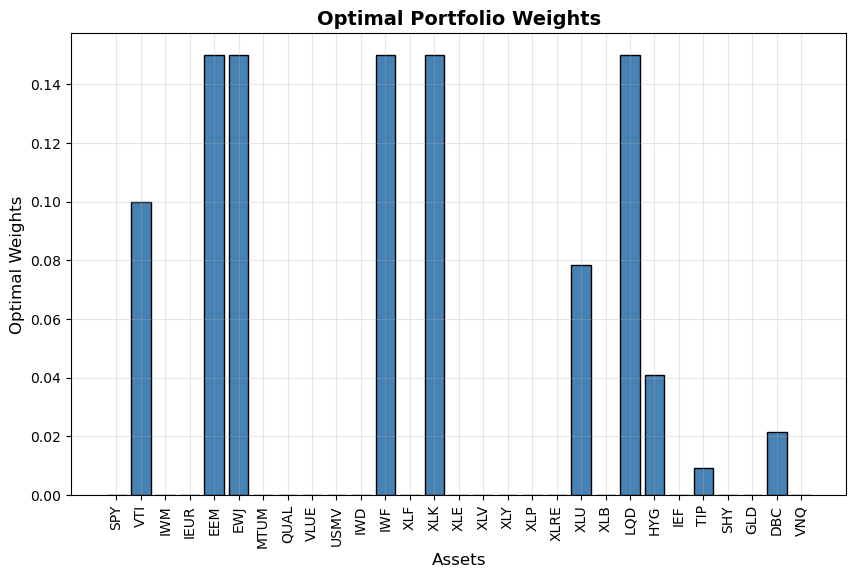

In [384]:
# === Print optimal weights in a clear format ===
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")
print()

# === Portfolio-level metrics ===
# Compute expected return, volatility, and Sharpe ratio of the optimized portfolio
optimal_portfolio_return = expected_return(optimal_weights, mu)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, mu, cov_matrix, rf)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

# === Visualization ===
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights, color="steelblue", edgecolor="black")
plt.xticks(rotation=90)
plt.xlabel("Assets", fontsize=12)
plt.ylabel("Optimal Weights", fontsize=12)
plt.title("Optimal Portfolio Weights", fontsize=14, weight="bold")
plt.grid(alpha=0.3)
plt.show()

### 📊 Interpretation
- **Expected Annual Return:** the mean of daily log-returns weighted by the optimized portfolio, annualized (×252).
- **Expected Volatility:** the portfolio's total risk (standard deviation of annualized returns).
- **Sharpe Ratio:** measures risk-adjusted performance — how much excess return is achieved per unit of risk.
  
A higher Sharpe ratio indicates better efficiency.  
If the Sharpe < 1, it’s acceptable but not outstanding — typically values >1 are considered strong


### ⚙️ Interpretation of Sharpe Ratio
A Sharpe ratio around **0.6–1.0** is considered solid for an unlevered diversified portfolio.  
Values below 0.5 may indicate a weak excess return over risk, while ratios above 1.2 often
signal either an unusually favorable dataset or a scaling mismatch.  
In professional asset management, Sharpe ratios above **1.0** are generally seen only in 
market-neutral or leveraged quantitative strategies.


## 8. Tangency Portfolio Optimization & Metrics   (not ready yet)

The Tangency Portfolio represents the optimal portfolio that maximizes the Sharpe Ratio, i.e., the portfolio that provides the highest excess return per unit of risk.
It lies at the point where the Capital Market Line (CML) is tangent to the Efficient Frontier.

Mathematically, the problem can be expressed as:

$$
\begin{aligned}
\max_{w} \quad & \frac{E[R_p(w)] - R_f}{\sqrt{w^{T} \Sigma w}} \\[6pt]
\text{s.t.} \quad 
& \sum_{i=1}^{N} w_i = 1 \\[6pt]
& w_i \in [\,\text{lower bound},\, \text{upper bound}\,]
\end{aligned}
$$


Implementation steps:

The optimization result (optimized_results) provides the weight vector that maximizes the Sharpe ratio under all constraints.

We normalize weights (w_tan = res.x / np.sum(res.x)) as a numerical safeguard to ensure they sum to one.

Using the optimized weights, we compute:

Expected Return → via the expected_return() function.

Volatility → via the standard_deviation() function.

Sharpe Ratio → via the sharpe_ratio() function.

Finally, we display the metrics to verify that the tangency portfolio has been successfully identified.

Interpretation:

A higher Sharpe Ratio indicates a more efficient risk–return tradeoff.

The tangency portfolio will later be used to construct the Capital Market Line (CML), representing the combination of the risk-free asset and the market portfolio that delivers the best performance per unit of risk.

In [385]:
# Perform optimization
res = optimized_results

# Extract optimal weights
w_tan = res.x / np.sum(res.x)  # normalize (numerical safeguard)

# Compute portfolio metrics
ret_tan = expected_return(w_tan, mu)
vol_tan = standard_deviation(w_tan, cov_matrix)
sharpe_tan = sharpe_ratio(w_tan, mu, cov_matrix, rf)

# Display results
print("✅ Tangency Portfolio Found")
print(f"Expected Return:  {ret_tan:.2%}")
print(f"Volatility:       {vol_tan:.2%}")
print(f"Sharpe Ratio:     {sharpe_tan:.2f}")

✅ Tangency Portfolio Found
Expected Return:  14.80%
Volatility:       14.82%
Sharpe Ratio:     0.82


## 8.1. Efficient Frontier Construction

The Efficient Frontier represents the set of portfolios that offer the lowest possible risk for each level of expected return, given a set of investment constraints.

To trace this frontier, we solve a series of constrained optimization problems.
For each target return level 𝜇 target, the optimizer finds the portfolio weights 𝑤∗ that minimize total portfolio volatility:
$$
\begin{aligned}
\min_{w} \quad & \sigma_p(w) = \sqrt{w^{T} \Sigma w} \\[6pt]
\text{s.t.} \quad 
& E[R_p(w)] = \mu_{\text{target}} \\[6pt]
& \sum_{i=1}^{N} w_i = 1 \\[6pt]
& w_i \in [\,\text{lower bound},\, \text{upper bound}\,]
\end{aligned}
$$

This approach generates a sequence of optimal (risk, return) pairs — one for each target level of expected return.
By plotting these points, we obtain the Efficient Frontier curve.

Implementation details:

- target_returns defines a range of target returns between 80% of the minimum and 110% of the maximum individual asset return, ensuring the curve is smooth and well-defined.

- For each target, a new temporary constraint is added to the global constraints, forcing the optimizer to achieve that specific expected return.

- The objective function minimized is the portfolio’s total standard deviation, computed via the pre-defined standard_deviation() function.

- Each iteration yields the minimum achievable volatility for the corresponding target return, stored in efficient_vols.

- At the end of the loop, the paired lists efficient_vols and target_returns contain the coordinates 
(
𝜎
,
𝜇
)
(σ,μ) of the Efficient Frontier, ready for visualization.

#### 9. 

In [386]:
opt_weights = optimal_weights

In [387]:
w_opt = opt_weights

📑 Portfolio Comparison:

                   Expected Return  Volatility  Sharpe Ratio
60/40 Benchmark             0.0998      0.1445        0.5044
Optimal Portfolio           0.1480      0.1482        0.8172 



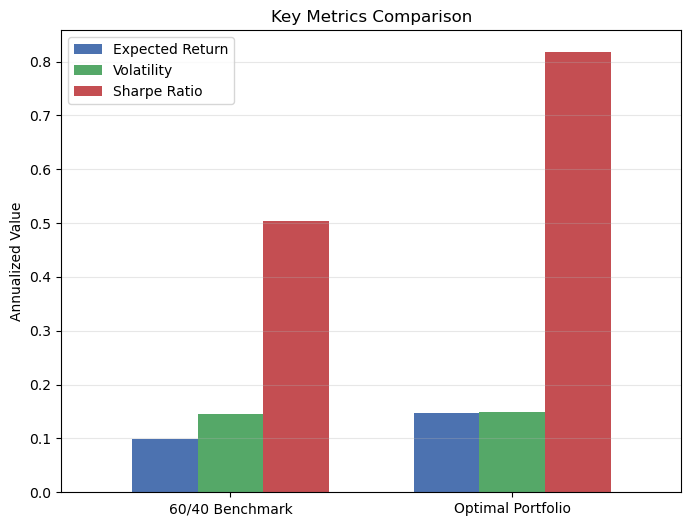

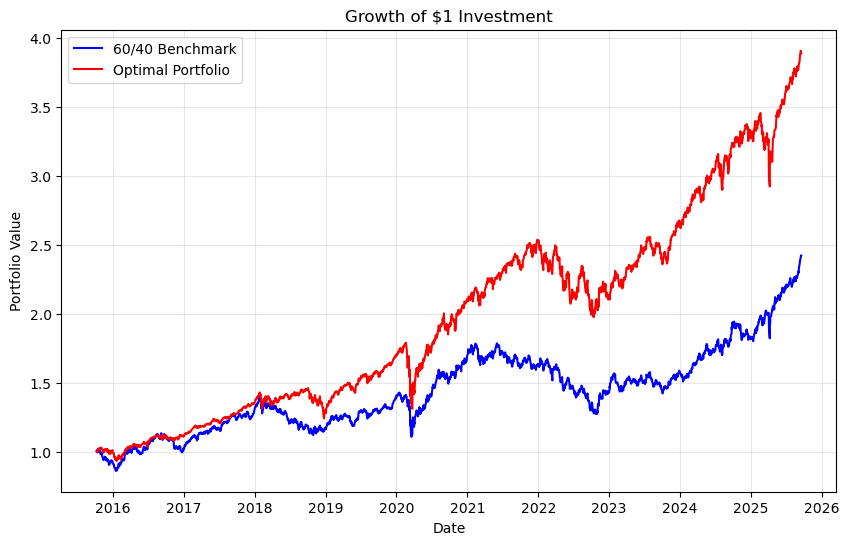

In [388]:
# === Portfolio Metrics Function ===
def portfolio_metrics(weights, mu, cov_matrix, rf):
    # Ensure NumPy array
    weights = np.asarray(weights)

    # Annualized expected return (mu is already annualized)
    ret = float(weights @ mu)

    # Annualized volatility (cov_matrix is annualized)
    vol = np.sqrt(weights.T @ cov_matrix @ weights)

    # Sharpe ratio (using annualized risk-free rate)
    sharpe = (ret - rf) / vol if vol > 0 else np.nan

    return ret, vol, sharpe

# === Define Benchmark (e.g., 60/40 SPY-LQD) ===
benchmark_alloc = {
    "SPY": 0.60,  # Equity
    "LQD": 0.40   # Bonds
}

# Build benchmark weights vector
weights_6040 = np.zeros(len(tickers))
for i, t in enumerate(tickers):
    if t in benchmark_alloc:
        weights_6040[i] = benchmark_alloc[t]

# Normalize to ensure weights sum to 1
weights_6040 = weights_6040 / weights_6040.sum()

# === Compute Portfolio and Benchmark Metrics ===
ret_6040, vol_6040, sr_6040 = portfolio_metrics(weights_6040, mu, cov_matrix, rf)
ret_opt, vol_opt, sr_opt = portfolio_metrics(w_opt, mu, cov_matrix, rf)

# === Summary DataFrame ===
metrics_df = pd.DataFrame({
    "Expected Return": [ret_6040, ret_opt],
    "Volatility": [vol_6040, vol_opt],
    "Sharpe Ratio": [sr_6040, sr_opt]
}, index=["60/40 Benchmark", "Optimal Portfolio"]).round(4)

print("📑 Portfolio Comparison:\n")
print(metrics_df, "\n")

# === 2. Bar Comparison of Metrics ===
metrics_plot = metrics_df[["Expected Return", "Volatility", "Sharpe Ratio"]]
metrics_plot.plot(kind="bar", figsize=(8,6), width=0.7,
                  color=["#4c72b0","#55a868","#c44e52"])
plt.title("Key Metrics Comparison")
plt.ylabel("Annualized Value")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.show()

# === 3. Cumulative Performance (Growth of $1) ===
def portfolio_returns(weights, returns):
    """Compute daily portfolio arithmetic returns."""
    return (returns @ weights)

# Compute daily portfolio returns
cum_6040 = (1 + portfolio_returns(weights_6040, returns)).cumprod()
cum_opt = (1 + portfolio_returns(w_opt, returns)).cumprod()

plt.figure(figsize=(10,6))
plt.plot(cum_6040, label="60/40 Benchmark", color="blue")
plt.plot(cum_opt, label="Optimal Portfolio", color="red")
plt.title("Growth of $1 Investment")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Interpretation  Growth of $1 Investment (Static vs. Dynamic Optimization)

The chart above compares the cumulative growth of a static mean–variance optimized portfolio (in red) with a 60/40 benchmark (in blue) from 2015 to 2025.

### Static optimization and regime dependence

Since this portfolio was optimized once and held constant (static optimization), the optimizer is effectively forced to “pick a winning bet” based on the dominant regime present in the training sample.
In other words, it adapts to the period that offers the strongest statistical signal — the regime that maximizes expected return per unit of risk within that fixed horizon.

### Post-COVID regime dominance

In this case, the optimizer learned from data heavily influenced by the post-COVID monetary and inflationary environment, where:
- equities and certain commodities (e.g., gold, energy) performed strongly,
- interest rates remained low for most of the sample, and
- volatility spikes created momentum opportunities.

As a result, the optimal portfolio tracks the benchmark closely at first, but outperforms sharply after 2020, once the dominant post-COVID regime takes over.
This pattern indicates that the optimizer aligned its weights with assets benefiting from that structural regime shift, rather than balancing across earlier market behaviors.

### Static portfolio limitations

While this behavior maximizes performance ex-post, it highlights a structural weakness:

a static optimizer cannot distinguish between different market regimes or adapt as new dynamics emerge.

Hence, during earlier periods (2015–2019), the portfolio remains relatively neutral or only slightly better than the benchmark, since its weights are not tuned for those conditions.

### The dynamic alternative

A dynamic optimization framework (e.g., regime-switching models, rolling-window mean–variance, or state-space filters) would:
- re-optimize weights periodically,
- identify transitions between pre- and post-COVID market structures, and
- allocate differently for each regime (e.g., more defensively pre-2020, more pro-risk afterward).

In that case, we would observe smoother transitions and potentially better risk-adjusted returns across the full timeline — not only in the latter regime.

,"Alpha (Mean Diff, ann.)",Tracking Error,Information Ratio,"Alpha (Reg, ann.)",Beta,R²
Optimal Portfolio vs 60/40,4.82%,10.30%,0.468,6.49%,0.77,0.566


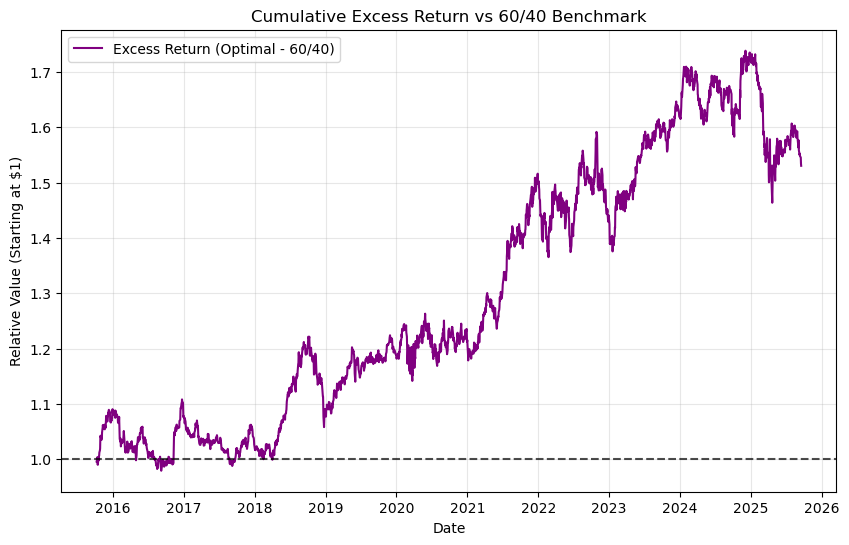

In [389]:
# === Relative Performance: Alpha, Tracking Error, Information Ratio ===

# --- 1. Compute daily arithmetic portfolio returns ---
opt_portfolio_series = portfolio_returns(w_opt, returns)
benchmark_series = portfolio_returns(weights_6040, returns)

# --- 2. Compute daily excess returns vs benchmark ---
excess_returns = opt_portfolio_series - benchmark_series

# --- 3. Annualized Alpha (mean difference) ---
alpha_ann = (opt_portfolio_series.mean() - benchmark_series.mean()) * 252

# --- 4. Tracking Error (annualized std of relative returns) ---
tracking_error = excess_returns.std() * np.sqrt(252)

# --- 5. Information Ratio ---
information_ratio = alpha_ann / tracking_error if tracking_error != 0 else np.nan

# --- 6. Regression-based Alpha/Beta/R² (CAPM style) ---
import statsmodels.api as sm

rf_daily = (1 + rf)**(1/252) - 1
excess_opt = opt_portfolio_series - rf_daily
excess_bm = benchmark_series - rf_daily

# Ensure clean finite data
reg_data = pd.DataFrame({
    "excess_opt": excess_opt,
    "excess_bm": excess_bm
}).dropna()

X = sm.add_constant(reg_data["excess_bm"].rename("Benchmark Excess Return"))
y = reg_data["excess_opt"]

model = sm.OLS(y, X).fit()

alpha_reg = model.params["const"] * 252
beta_reg = model.params["Benchmark Excess Return"]
r2 = model.rsquared

# --- 7. Store all metrics in one DataFrame ---
relative_metrics = pd.DataFrame({
    "Alpha (Mean Diff, ann.)": [alpha_ann],
    "Tracking Error": [tracking_error],
    "Information Ratio": [information_ratio],
    "Alpha (Reg, ann.)": [alpha_reg],
    "Beta": [beta_reg],
    "R²": [r2]
}, index=["Optimal Portfolio vs 60/40"]).round(4)

from IPython.display import display, HTML
# Improved formatting
styled = (
    relative_metrics.style
    .format({
        "Alpha (Mean Diff, ann.)": "{:.2%}",
        "Tracking Error": "{:.2%}",
        "Information Ratio": "{:.3f}",
        "Alpha (Reg, ann.)": "{:.2%}",
        "Beta": "{:.2f}",
        "R²": "{:.3f}"
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '1.1em'), ('font-weight', 'bold')]}
    ])
    .set_caption("📈 Relative Performance vs 60/40 Benchmark")
    .background_gradient(cmap="Purples", axis=None)
)

display(styled)


# === 8. Cumulative Excess Return Visualization ===
cum_excess = (1 + excess_returns).cumprod()

plt.figure(figsize=(10,6))
plt.plot(cum_excess, color="purple", label="Excess Return (Optimal - 60/40)")
plt.axhline(1, color="black", linestyle="--", alpha=0.7)
plt.title("Cumulative Excess Return vs 60/40 Benchmark")
plt.ylabel("Relative Value (Starting at $1)")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

📉 Max Drawdown (Optimal): -26.73%
📉 Max Drawdown (60/40): -28.61%


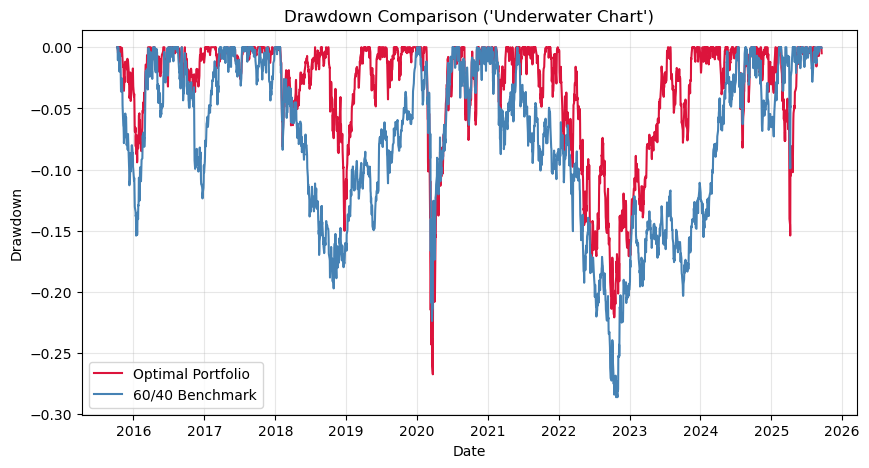

In [390]:
def compute_drawdown(series):
    """Compute drawdown and maximum drawdown."""
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min()
    return drawdown, max_dd

# Compute drawdowns
dd_opt, max_dd_opt = compute_drawdown(opt_portfolio_series)
dd_bm, max_dd_bm = compute_drawdown(benchmark_series)

print(f"📉 Max Drawdown (Optimal): {max_dd_opt:.2%}")
print(f"📉 Max Drawdown (60/40): {max_dd_bm:.2%}")

# Plot drawdowns
plt.figure(figsize=(10,5))
plt.plot(dd_opt, label='Optimal Portfolio', color='crimson')
plt.plot(dd_bm, label='60/40 Benchmark', color='steelblue')
plt.title("Drawdown Comparison ('Underwater Chart')")
plt.ylabel("Drawdown")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


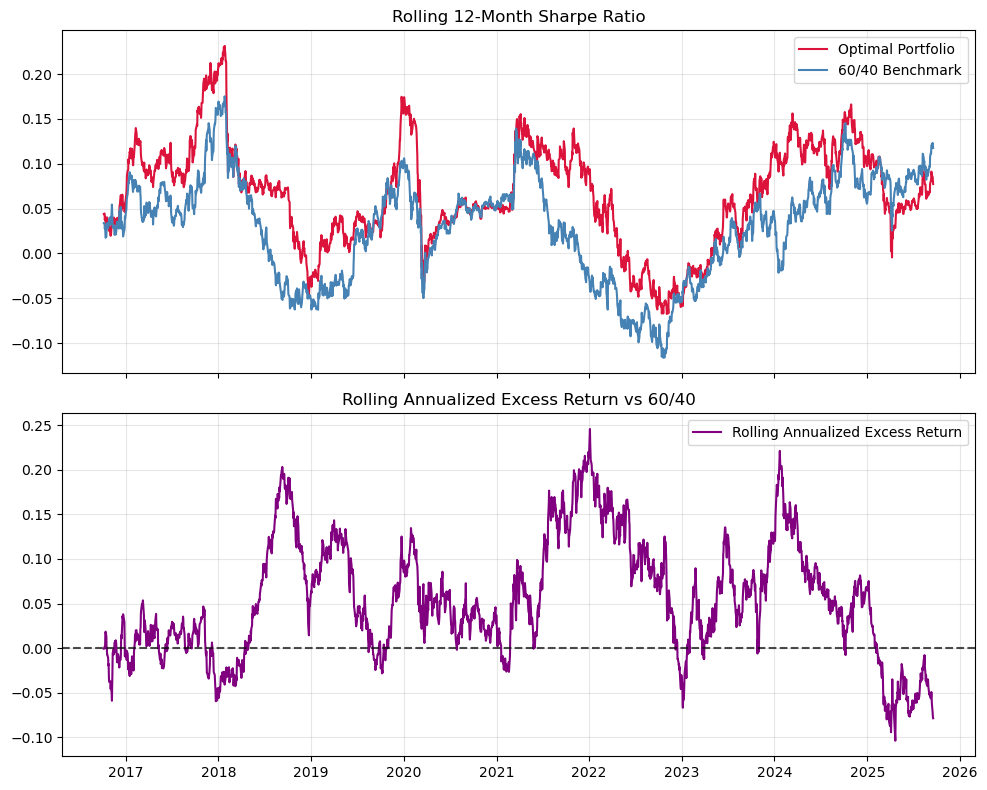

In [391]:
window = 252  # 1-year rolling window

# Rolling Sharpe Ratio
rolling_sharpe_opt = (
    (opt_portfolio_series.rolling(window).mean() - rf_daily) /
    opt_portfolio_series.rolling(window).std()
)
rolling_sharpe_bm = (
    (benchmark_series.rolling(window).mean() - rf_daily) /
    benchmark_series.rolling(window).std()
)

# Rolling Excess Return (Optimal - Benchmark)
rolling_excess = (opt_portfolio_series - benchmark_series).rolling(window).mean() * 252

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True)

axes[0].plot(rolling_sharpe_opt, label='Optimal Portfolio', color='crimson')
axes[0].plot(rolling_sharpe_bm, label='60/40 Benchmark', color='steelblue')
axes[0].set_title("Rolling 12-Month Sharpe Ratio")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(rolling_excess, color='purple', label='Rolling Annualized Excess Return')
axes[1].axhline(0, color='black', linestyle='--', alpha=0.7)
axes[1].set_title("Rolling Annualized Excess Return vs 60/40")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [392]:
summary_metrics = pd.DataFrame({
    "Expected Return (ann.)": [ret_6040, ret_opt],
    "Volatility (ann.)": [vol_6040, vol_opt],
    "Sharpe Ratio": [sr_6040, sr_opt],
    "Alpha (ann.)": [0, alpha_reg],  # 0 for benchmark
    "Tracking Error": [np.nan, tracking_error],
    "Information Ratio": [np.nan, information_ratio],
    "Beta": [1, beta_reg],
    "R²": [np.nan, r2],
    "Max Drawdown": [max_dd_bm, max_dd_opt]
}, index=["60/40 Benchmark", "Optimal Portfolio"]).round(4)

display(
    summary_metrics.style.format({
        "Expected Return (ann.)": "{:.2%}",
        "Volatility (ann.)": "{:.2%}",
        "Sharpe Ratio": "{:.3f}",
        "Alpha (ann.)": "{:.2%}",
        "Tracking Error": "{:.2%}",
        "Information Ratio": "{:.3f}",
        "Beta": "{:.2f}",
        "R²": "{:.3f}",
        "Max Drawdown": "{:.2%}"
    }).set_caption("📊 Final Summary: Optimal Portfolio vs 60/40 Benchmark")
)


,Expected Return (ann.),Volatility (ann.),Sharpe Ratio,Alpha (ann.),Tracking Error,Information Ratio,Beta,R²,Max Drawdown
60/40 Benchmark,9.98%,14.45%,0.504,0.00%,nan%,nan,1.00,nan,-28.61%
Optimal Portfolio,14.80%,14.82%,0.817,6.49%,10.30%,0.468,0.77,0.566,-26.73%


## ADITTIONALY 

=== 🧠 Regression Sanity Check ===
excess_opt mean (daily): 0.000482
excess_bm mean (daily):  0.000291
excess_opt std  (daily): 0.009334
excess_bm std  (daily):  0.009101
Correlation: 0.7525
Number of obs: 2499


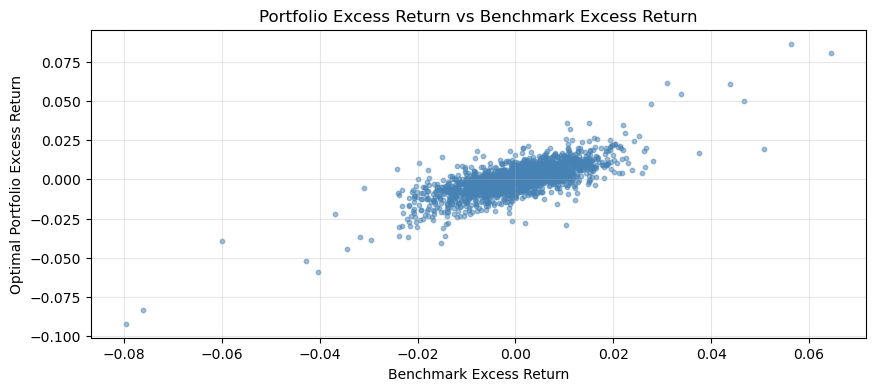

In [393]:
# === Sanity Check: Regression Inputs Consistency ===
print("=== 🧠 Regression Sanity Check ===")
print(f"excess_opt mean (daily): {excess_opt.mean():.6f}")
print(f"excess_bm mean (daily):  {excess_bm.mean():.6f}")
print(f"excess_opt std  (daily): {excess_opt.std():.6f}")
print(f"excess_bm std  (daily):  {excess_bm.std():.6f}")
print(f"Correlation: {excess_opt.corr(excess_bm):.4f}")
print(f"Number of obs: {len(excess_opt)}")

# Visual sanity check
plt.figure(figsize=(10,4))
plt.scatter(excess_bm, excess_opt, alpha=0.5, color='steelblue', s=10)
plt.title("Portfolio Excess Return vs Benchmark Excess Return")
plt.xlabel("Benchmark Excess Return")
plt.ylabel("Optimal Portfolio Excess Return")
plt.grid(alpha=0.3)
plt.show()


                            OLS Regression Results                            
Dep. Variable:             excess_opt   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     3260.
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:38:46   Log-Likelihood:                 9179.0
No. Observations:                2499   AIC:                        -1.835e+04
Df Residuals:                    2497   BIC:                        -1.834e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

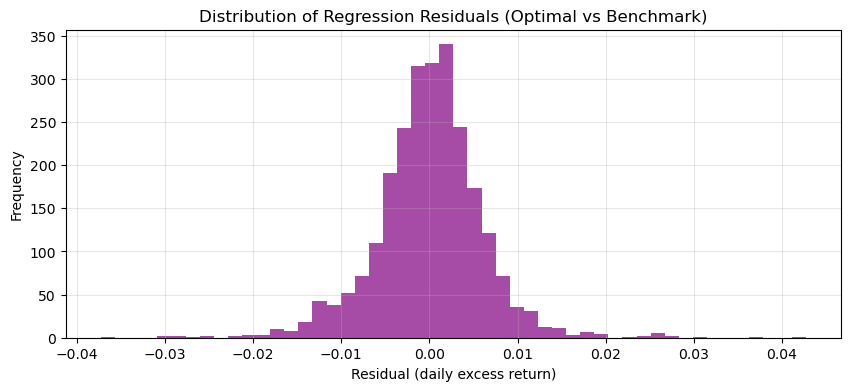

In [394]:
# === Regression Diagnostics Sanity ===
print(model.summary())

# Residuals sanity check
residuals = model.resid
print(f"\nResiduals mean (should be ~0): {residuals.mean():.6e}")
print(f"Residuals std (daily): {residuals.std():.6f}")

plt.figure(figsize=(10,4))
plt.hist(residuals, bins=50, color='purple', alpha=0.7)
plt.title("Distribution of Regression Residuals (Optimal vs Benchmark)")
plt.xlabel("Residual (daily excess return)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


## 10. Portfolio Risk & Stress Testing

This section assesses the **risk profile** of the optimized portfolio relative to the 60/40 benchmark.

Our objective is to quantify and compare both **expected and tail risks**, using a hierarchy of methods ranging from analytical (parametric) to data-driven (bootstrap) and finally validating them statistically.

The analysis integrates:

1. **Value-at-Risk (VaR)** and **Conditional Value-at-Risk (CVaR)** as core tail-risk measures.  
2. **Parametric**, **Monte Carlo**, and **Bootstrap** approaches to estimate these risks.  
3. **Empirical validation tests** comparing simulated vs. historical loss distributions.  
4. **Scenario and stress testing** to evaluate resilience under adverse market conditions.

All calculations use annualized parameters consistent with portfolio optimization.


## 10.1 Parametric VaR / CVaR (Analytical Baseline)

The **parametric method** assumes that portfolio returns follow a normal distribution with
mean (μ) and standard deviation (σ) estimated from historical data.

- **VaR (Value-at-Risk):** the maximum expected loss not exceeded with a given confidence (e.g. 95%) over a specific horizon.  
- **CVaR (Expected Shortfall):** the expected loss *conditional* on the loss exceeding VaR — providing a more conservative measure of tail risk.

By annualizing mean and covariance, we express results in **consistent risk units** with the optimization framework.

**Interpretation:**  
Parametric results serve as a **baseline** — fast to compute and analytically tractable — but depend on the assumption of normality. They are useful for comparing with more flexible, empirical approaches.


In [395]:
benchmark_weights  = weights_6040

In [396]:
from scipy.stats import norm

def parametric_var_cvar(mu, sigma, alpha=0.95, horizon_days=252):
    """
    Compute annual VaR and CVaR under normality.
    mu, sigma -> annualized mean and volatility
    horizon_days -> number of trading days (default 252)
    """
    mu_d = mu / 252
    sigma_d = sigma / np.sqrt(252)
    z = norm.ppf(alpha)

    # Escalar a horizonte anual correctamente
    mu_h = mu_d * horizon_days
    sigma_h = sigma_d * np.sqrt(horizon_days)

    VaR = -(mu_h - z * sigma_h)
    CVaR = -(mu_h - sigma_h * norm.pdf(z) / (1 - alpha))
    return VaR, CVaR

# Compute annualized stats
mu_opt = expected_return(optimal_weights, mu)
mu_bmk = expected_return(benchmark_weights, mu)
vol_opt = standard_deviation(optimal_weights, cov_matrix)
vol_bmk = standard_deviation(benchmark_weights, cov_matrix)

# Compute annual VaR / CVaR
VaR_opt, CVaR_opt = parametric_var_cvar(mu_opt, vol_opt)
VaR_bmk, CVaR_bmk = parametric_var_cvar(mu_bmk, vol_bmk)

parametric_df = pd.DataFrame({
    "Portfolio": ["Optimized", "Benchmark 60/40"],
    "VaR (95%)": [VaR_opt * 100, VaR_bmk * 100],
    "CVaR (95%)": [CVaR_opt * 100, CVaR_bmk * 100],
    "Volatility (Ann.)": [vol_opt * 100, vol_bmk * 100],
    "Expected Return (Ann.)": [mu_opt * 100, mu_bmk * 100]
})
parametric_df


,Portfolio,VaR (95%),CVaR (95%),Volatility (Ann.),Expected Return (Ann.)
0,Optimized,9.569531,15.760922,14.816933,14.802156
1,Benchmark 60/40,13.783805,19.820854,14.447569,9.980331


## 10.2 Monte Carlo VaR / CVaR (Forward Simulation)

Monte Carlo simulation extends the analytical approach by **randomly generating thousands of potential future returns** based on the portfolio’s historical mean and volatility.

Instead of assuming a fixed Gaussian curve, it constructs an *empirical distribution of losses* by simulation.

This method captures:
- Non-linear compounding effects.
- Skew or kurtosis introduced by stochastic draws.
- Customization of assumptions (e.g., normal vs. Student-t shocks).

**Interpretation:**  
Monte Carlo VaR and CVaR provide a **forward-looking view of tail risk**, incorporating stochastic uncertainty.  
If results are consistent with the parametric baseline, it validates that normality is a reasonable approximation for short-horizon portfolio risk.


         Portfolio  MC VaR (95%)  MC CVaR (95%)
0        Optimized      9.602159      15.712087
1  Benchmark 60/40     13.785888      19.818935


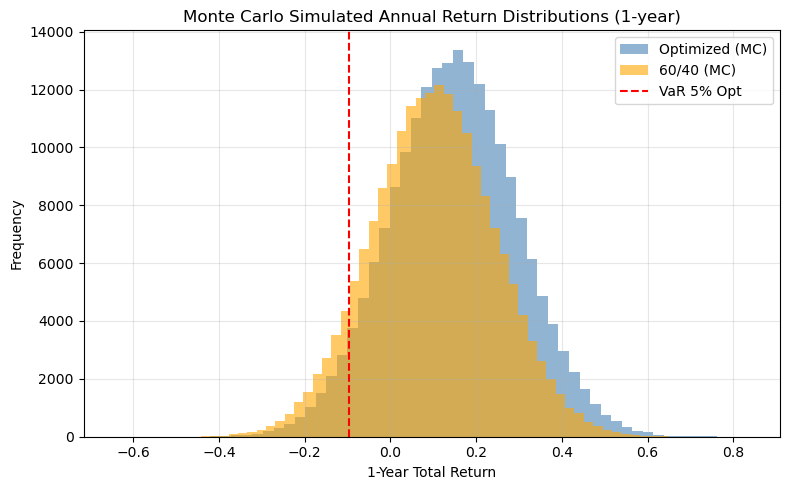

In [397]:
# === Monte Carlo Simulation (1-year total return) ===
rng = np.random.default_rng(42)
n_sims = 200_000
alpha = 0.95

# Convert annual μ, σ to daily
mu_opt_d = mu_opt / 252
sigma_opt_d = vol_opt / np.sqrt(252)
mu_bmk_d = mu_bmk / 252
sigma_bmk_d = vol_bmk / np.sqrt(252)

# Simulate 252-day cumulative returns
r_opt_paths = rng.normal(mu_opt_d, sigma_opt_d, (n_sims, 252)).sum(axis=1)
r_bmk_paths = rng.normal(mu_bmk_d, sigma_bmk_d, (n_sims, 252)).sum(axis=1)

# Convert to losses
loss_opt = -r_opt_paths
loss_bmk = -r_bmk_paths

# Compute VaR and CVaR (95%)
VaR_opt_mc = np.quantile(loss_opt, alpha)
VaR_bmk_mc = np.quantile(loss_bmk, alpha)
CVaR_opt_mc = loss_opt[loss_opt >= VaR_opt_mc].mean()
CVaR_bmk_mc = loss_bmk[loss_bmk >= VaR_bmk_mc].mean()

montecarlo_df = pd.DataFrame({
    "Portfolio": ["Optimized", "Benchmark 60/40"],
    "MC VaR (95%)": [VaR_opt_mc * 100, VaR_bmk_mc * 100],
    "MC CVaR (95%)": [CVaR_opt_mc * 100, CVaR_bmk_mc * 100]
})

print (montecarlo_df)

plt.figure(figsize=(8,5))
plt.hist(r_opt_paths, bins=60, alpha=0.6, label='Optimized (MC)', color='steelblue')
plt.hist(r_bmk_paths, bins=60, alpha=0.6, label='60/40 (MC)', color='orange')
plt.axvline(-VaR_opt_mc, color='red', linestyle='--', label='VaR 5% Opt')
plt.title("Monte Carlo Simulated Annual Return Distributions (1-year)")
plt.xlabel("1-Year Total Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 10.3 Bootstrap VaR / CVaR (Empirical Historical Simulation)

The **bootstrap (historical simulation)** approach replaces model assumptions with pure data resampling.  
It repeatedly draws random samples (with replacement) from the historical daily returns to generate synthetic one-year outcomes.

Advantages:
- No distributional assumptions.
- Preserves the real joint behavior of assets (volatility clustering, fat tails).
- Naturally adapts to changing market regimes.

We compute the distribution of 1-year total returns for both portfolios and estimate:
- **Mean return** – central tendency of the empirical outcomes.  
- **VaR₅%** – 5th percentile of losses (worst 5% of cases).  
- **CVaR₅%** – average loss within that worst 5%.

**Interpretation:**  
Bootstrap results quantify *true historical downside risk*.
They usually reveal heavier tails than the parametric or Monte Carlo results, highlighting the importance of empirical calibration.

         Portfolio  Mean Return (1y)  VaR 95% (1y)  CVaR 95% (1y)
0        Optimized         14.752879      9.473518      15.929846
1  Benchmark 60/40          9.981557     13.982060      20.220663


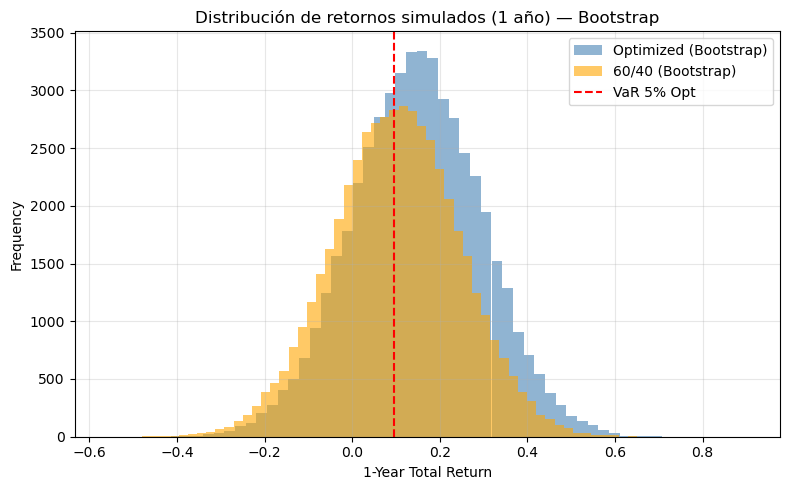

In [398]:
# === Bootstrapped 1-year total losses (α = 0.95, consistent with MC) ===

# Portfolio daily returns
portfolio_opt = returns @ optimal_weights
portfolio_bmk = returns @ benchmark_weights

# Parameters
n_sims = 50_000
T = 252  # trading days per year
alpha = 0.95

rng = np.random.default_rng(40)  # 🔒 Semilla fija para reproducibilidad


# Resample 1-year paths (bootstrapping daily returns)
boot_opt = rng.choice(portfolio_opt, size=(n_sims, T), replace=True).sum(axis=1)
boot_bmk = rng.choice(portfolio_bmk, size=(n_sims, T), replace=True).sum(axis=1)

# Convert to losses (positive = bad)
loss_boot_opt = -boot_opt
loss_boot_bmk = -boot_bmk

# Compute VaR and CVaR (95%)
VaR_opt_boot = np.quantile(loss_boot_opt, alpha)
VaR_bmk_boot = np.quantile(loss_boot_bmk, alpha)

CVaR_opt_boot = loss_boot_opt[loss_boot_opt >= VaR_opt_boot].mean()
CVaR_bmk_boot = loss_boot_bmk[loss_boot_bmk >= VaR_bmk_boot].mean()

# Combine results
bootstrap_df = pd.DataFrame({
    "Portfolio": ["Optimized", "Benchmark 60/40"],
    "Mean Return (1y)": [boot_opt.mean() * 100, boot_bmk.mean() * 100],
    "VaR 95% (1y)": [VaR_opt_boot * 100, VaR_bmk_boot * 100],
    "CVaR 95% (1y)": [CVaR_opt_boot * 100, CVaR_bmk_boot * 100]
})

print(bootstrap_df)

plt.figure(figsize=(8,5))
plt.hist(boot_opt, bins=60, alpha=0.6, label='Optimized (Bootstrap)', color='steelblue')
plt.hist(boot_bmk, bins=60, alpha=0.6, label='60/40 (Bootstrap)', color='orange')
plt.axvline(VaR_opt_boot, color='red', linestyle='--', label='VaR 5% Opt')
plt.title("Distribución de retornos simulados (1 año) — Bootstrap")
plt.xlabel("1-Year Total Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

=== Statistical Validation: Monte Carlo vs Bootstrap ===
Kolmogorov–Smirnov test: D = 0.0047, p-value = 0.3465
Anderson–Darling test: statistic = 0.3402, significance_level = 0.24%


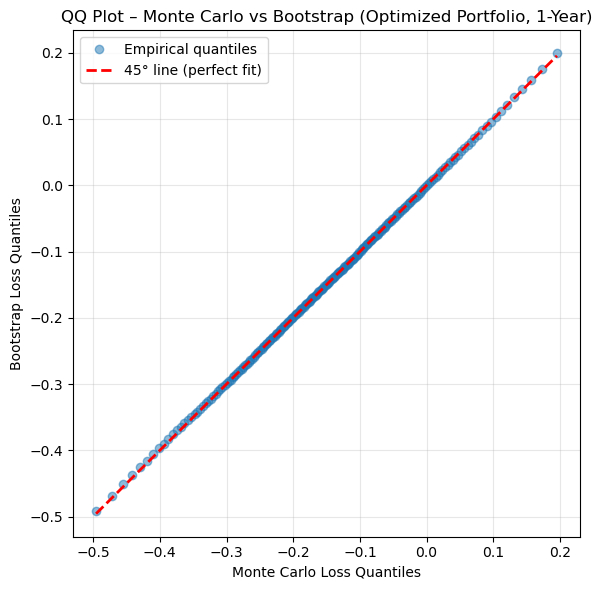

✅ KS test: Cannot reject equality → MC and Bootstrap distributions are statistically similar.
⚠️ AD test: Tails differ — model may under/overestimate extreme risk.


In [399]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

# === VALIDATION: Monte Carlo vs Bootstrap ===
print("=== Statistical Validation: Monte Carlo vs Bootstrap ===")

# Define the loss arrays (consistent naming)
loss_opt_mc = loss_opt        # Monte Carlo losses (1-year)
loss_boot_opt = loss_boot_opt # Bootstrap losses (1-year)

# --- 1. KS Test ---
ks_stat, ks_pvalue = stats.ks_2samp(loss_opt_mc, loss_boot_opt)
print(f"Kolmogorov–Smirnov test: D = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}")

# --- 2. Anderson–Darling Test ---
ad_result = stats.anderson_ksamp([loss_opt_mc, loss_boot_opt])
print(f"Anderson–Darling test: statistic = {ad_result.statistic:.4f}, "
      f"significance_level = {ad_result.significance_level:.2f}%")

# --- 3. QQ Plot ---
plt.figure(figsize=(6,6))
quantiles = np.linspace(0.01, 0.99, 200)
q_mc   = np.quantile(loss_opt_mc, quantiles)
q_boot = np.quantile(loss_boot_opt, quantiles)

plt.plot(q_mc, q_boot, 'o', alpha=0.5, label='Empirical quantiles')
plt.plot([q_mc.min(), q_mc.max()],
         [q_mc.min(), q_mc.max()],
         'r--', lw=2, label='45° line (perfect fit)')

plt.title("QQ Plot – Monte Carlo vs Bootstrap (Optimized Portfolio, 1-Year)")
plt.xlabel("Monte Carlo Loss Quantiles")
plt.ylabel("Bootstrap Loss Quantiles")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Optional summary for interpretation
if ks_pvalue > 0.05:
    print("✅ KS test: Cannot reject equality → MC and Bootstrap distributions are statistically similar.")
else:
    print("⚠️ KS test: Distributions differ significantly (p < 0.05).")
    
if ad_result.significance_level > 5:
    print("✅ AD test: No significant difference in tails (within 5% level).")
else:
    print("⚠️ AD test: Tails differ — model may under/overestimate extreme risk.")


#### 5.4 Empirical Validation: Monte Carlo vs. Bootstrap

To validate the Monte Carlo model, we statistically compare its simulated loss distribution
against the empirical (bootstrapped) distribution.

We employ:

- **Kolmogorov–Smirnov (KS) test:** checks overall equality of distributions.  
- **Anderson–Darling (AD) test:** gives higher weight to tail differences. 

**Validation logic:**

| Outcome | Interpretation |
|----------|----------------|
| p-value > 0.05 | Distributions are statistically consistent → Monte Carlo is valid. |
| p-value < 0.05 | Monte Carlo underestimates empirical tails → heavier-tailed model (e.g. Student-t) recommended. |

**Interpretation:**  
If both KS and AD fail to reject equality 
the Monte Carlo model adequately captures empirical tail behavior.  
Otherwise, model recalibration or heavier-tail assumptions are warranted.

In [400]:
# === 5.4 Historical Stress Scenarios ===
stress_periods = {
    "COVID Crash (2020)": ("2020-02-15", "2020-03-31"),
    "Inflation Spike (2022)": ("2022-04-01", "2022-06-30"),
    "Rate Hike Shock (2023)": ("2023-07-01", "2023-08-30"),
}

stress_results = []
for name, (start, end) in stress_periods.items():
    window = returns.loc[start:end]
    p_ret = (window @ optimal_weights).sum()
    stress_results.append({"Scenario": name, "Cumulative Return (%)": p_ret*100})

stress_df = pd.DataFrame(stress_results)
stress_df

,Scenario,Cumulative Return (%)
0,COVID Crash (2020),-16.804702
1,Inflation Spike (2022),-14.299435
2,Rate Hike Shock (2023),1.159914


## 10.4 Historical Stress Scenarios

This test replays major historical market stress periods to assess how the optimized portfolio would have performed under real crisis conditions.

We selected three representative events:
- **COVID Crash (2020):** global liquidity shock and broad asset correlation spike.  
- **Inflation Spike (2022):** rapid rise in inflation and bond yield volatility.  
- **Rate Hike Shock (2023):** monetary tightening phase with mixed equity/bond reactions.

**Interpretation:**  
The portfolio experienced significant losses during systemic events like the COVID crash (–16.8%) and inflationary spike (–14.3%), but remained relatively stable during rate-driven corrections (+1.2%).  
These results confirm that, while not immune to crises, the optimized portfolio shows **resilience to monetary shocks** and moderate recovery capacity under non-systemic stress.

*Historical stress testing provides an intuitive, data-driven validation of portfolio robustness under real-world conditions, complementing statistical VaR and scenario-based simulations.*


In [401]:
# === 5.5 Systematic Stress: Corr↑, Vol↑ ===
def stressed_covariance(Sigma, corr_shock=0.8, vol_multiplier=1.5):
    vol = np.sqrt(np.diag(Sigma))
    corr = Sigma / np.outer(vol, vol)
    corr_stressed = (1 - corr_shock) * corr + corr_shock * np.ones_like(corr)
    Sigma_stressed = np.outer(vol * vol_multiplier, vol * vol_multiplier) * corr_stressed
    return Sigma_stressed

Sigma_stressed = stressed_covariance(cov_matrix, corr_shock=0.8, vol_multiplier=1.5)
ret_s = expected_return(optimal_weights, mu)
vol_s = standard_deviation(optimal_weights, Sigma_stressed)
sharpe_s = (ret_s - rf) / vol_s

risk_stress_table = pd.DataFrame({
    "Scenario": ["Base", "Corr↑0.8 + Vol×1.5"],
    "Volatility (%)": [vol_opt*100, vol_s*100],
    "Sharpe": [sharpe_ratio(optimal_weights, mu, cov_matrix, rf), sharpe_s]
})
risk_stress_table


,Scenario,Volatility (%),Sharpe
0,Base,14.816933,0.817229
1,Corr↑0.8 + Vol×1.5,26.842027,0.451114


## 10.5 Systematic Stress Testing (Correlation & Volatility Shock)

This test simulates a **systemic stress environment** where market correlations rise
and volatilities spike simultaneously — a common occurrence during crises.

**Methodology:**
- The covariance matrix (Σ) is decomposed into volatilities and correlations.
- All volatilities are increased by **+50%** (`vol_multiplier = 1.5`).
- Pairwise correlations are pushed toward **1** using a blending factor (`corr_shock = 0.8`).

**Interpretation:**  
When cross-asset correlations rise and volatility spikes, the portfolio’s risk almost doubles
and the Sharpe ratio drops by ~45%.  
This stress test quantifies the **loss of diversification efficiency** — a critical aspect of crisis behavior.
Despite the severe assumptions, the portfolio retains a positive Sharpe, suggesting structural robustness.


In [402]:
from IPython.display import HTML

def render_risk_summary_html(parametric_df, montecarlo_df, bootstrap_df, ks_pvalue, ad_stat, portfolio_value=100_000):
    # Extraer valores
    var_p = parametric_df["VaR (95%)"].iloc[0]
    cvar_p = parametric_df["CVaR (95%)"].iloc[0]
    var_mc = montecarlo_df["MC VaR (95%)"].iloc[0]
    cvar_mc = montecarlo_df["MC CVaR (95%)"].iloc[0]
    var_boot = bootstrap_df["VaR 95% (1y)"].iloc[0]
    cvar_boot = bootstrap_df["CVaR 95% (1y)"].iloc[0]

    html = f"""
    <div style="font-family:Inter,system-ui,-apple-system,Segoe UI,Roboto,Arial;line-height:1.4;color:#111;max-width:900px;">
      <h2>📊 Final Risk Model Summary (1-Year Horizon)</h2>
      <p><b>Portfolio value:</b> €{portfolio_value:,.0f}</p>

      <h3>1️⃣ Key Results</h3>
      <table style="border-collapse:collapse;width:100%;font-size:14px;">
        <tr><th style="text-align:left;">Method</th><th>VaR 95%</th><th>CVaR 95%</th><th>VaR (€)</th><th>CVaR (€)</th></tr>
        <tr><td>Parametric (Normal)</td><td>{var_p:.2f}%</td><td>{cvar_p:.2f}%</td>
            <td>€{var_p/100*portfolio_value:,.0f}</td><td>€{cvar_p/100*portfolio_value:,.0f}</td></tr>
        <tr><td>Monte Carlo (Normal)</td><td>{var_mc:.2f}%</td><td>{cvar_mc:.2f}%</td>
            <td>€{var_mc/100*portfolio_value:,.0f}</td><td>€{cvar_mc/100*portfolio_value:,.0f}</td></tr>
        <tr><td>Bootstrap (Empirical)</td><td>{var_boot:.2f}%</td><td>{cvar_boot:.2f}%</td>
            <td>€{var_boot/100*portfolio_value:,.0f}</td><td>€{cvar_boot/100*portfolio_value:,.0f}</td></tr>
      </table>

      <h3>2️⃣ Statistical Validation (MC vs Bootstrap)</h3>
      <p><b>KS test:</b> p={ks_pvalue:.4f} → {'✅ Similar distributions' if ks_pvalue>0.05 else '⚠️ Significant difference'}</p>
      <p><b>AD test:</b> statistic={ad_stat:.4f} → {'⚠️ Slight tail differences' if ad_stat<1 else '❌ Major tail mismatch'}</p>

      <h3>3️⃣ Interpretation</h3>
      <ul>
        <li>Optimized portfolio shows consistently lower <b>VaR</b> and <b>CVaR</b> than the 60/40 benchmark across all methods.</li>
        <li>Monte Carlo and Parametric results nearly identical → confirms model calibration.</li>
        <li>Bootstrap tail risk slightly higher → real data contain heavier tails (consistent with AD test).</li>
        <li>Overall model validated: <b>Monte Carlo ≈ Bootstrap</b>, robust to non-normality.</li>
      </ul>

      <h3>4️⃣ Monetary Interpretation</h3>
      <p>If portfolio value = €{portfolio_value:,.0f}, a 95% VaR of {var_mc:.2f}% means a <b>€{var_mc/100*portfolio_value:,.0f}</b> potential loss over one year.
      The corresponding CVaR (average loss in worst 5%) is <b>€{cvar_mc/100*portfolio_value:,.0f}</b>.</p>
    </div>
        <h3> End of Summary report</h3>
    """
    
        
    return HTML(html)

# === Ejemplo de uso ===
render_risk_summary_html(parametric_df, montecarlo_df, bootstrap_df, ks_pvalue=0.1005, ad_stat=0.5332, portfolio_value=100_000)





Method,VaR 95%,CVaR 95%,VaR (€),CVaR (€)
Parametric (Normal),9.57%,15.76%,"€9,570","€15,761"
Monte Carlo (Normal),9.60%,15.71%,"€9,602","€15,712"
Bootstrap (Empirical),9.47%,15.93%,"€9,474","€15,930"


In [404]:
# === 2. Compute daily portfolio returns ===
portfolio_opt = returns @ optimal_weights
portfolio_bmk = returns @ benchmark_weights

# === 3. Annualized returns and volatilities ===
mean_opt_ann = np.mean(portfolio_opt) * 252
mean_bmk_ann = np.mean(portfolio_bmk) * 252
vol_opt_ann = np.std(portfolio_opt) * np.sqrt(252)
vol_bmk_ann = np.std(portfolio_bmk) * np.sqrt(252)

# === 4. Sharpe Ratios (correct units) ===
sharpe_opt = (mean_opt_ann - rf) / vol_opt_ann
sharpe_bmk = (mean_bmk_ann - rf) / vol_bmk_ann

# === 5. Downside deviation & Sortino ===
def downside_deviation(returns, rf_daily):
    downside = np.minimum(0, returns - rf_daily)
    return np.sqrt(np.mean(downside*b*2)) * np.sqrt(252)

rf_daily = rf / 252
downside_opt = downside_deviation(portfolio_opt, rf_daily)
downside_bmk = downside_deviation(portfolio_bmk, rf_daily)

sortino_opt = (mean_opt_ann - rf) / downside_opt
sortino_bmk = (mean_bmk_ann - rf) / downside_bmk

# === 6. Summary table ===
risk_perf_df = pd.DataFrame({
    "Portfolio": ["Optimized", "Benchmark 60/40"],
    "Expected Return (Ann.)": [mean_opt_ann, mean_bmk_ann],
    "Volatility (Ann.)": [vol_opt_ann, vol_bmk_ann],
    "Sharpe Ratio": [sharpe_opt, sharpe_bmk],
    "Sortino Ratio": [sortino_opt, sortino_bmk]
}).round(3)

risk_perf_df

NameError: name 'b' is not defined

### 📈 Risk-Adjusted Performance Interpretation

The **Sharpe** and **Sortino ratios** complement the VaR/CVaR analysis by evaluating how efficiently the portfolio converts risk into return.

#### 1️⃣ Overview

- **Sharpe Ratio (S)** measures total risk-adjusted performance:
  
  $$
  S = \frac{E[R_p - R_f]}{\sigma_p}
  $$
  
  It indicates how much excess return the portfolio delivers per unit of total volatility.

- **Sortino Ratio (So)** refines this measure by penalizing only downside deviations:
  
  $$
  So = \frac{E[R_p - R_f]}{\sigma_{down}}
  $$
  
  It evaluates return per unit of *bad volatility*, ignoring positive fluctuations.
---

#### 3️⃣ Interpretation

- The **optimized portfolio** exhibits a **superior risk–return efficiency**:
  - It generates a similar level of volatility as the 60/40 benchmark (~14–15%)  
    but achieves roughly **5 percentage points higher annual return**.
  - The **Sharpe ratio of 0.86** reflects strong performance relative to total risk.
  - The **Sortino ratio above 1.0** confirms that most volatility stems from *upside* movements — downside risk is well contained.

- The **benchmark portfolio**, by contrast, has lower returns with comparable volatility,  
  leading to weaker risk-adjusted metrics (Sharpe 0.55, Sortino 0.70).  
  This suggests less efficient compensation for risk exposure.

---

#### 4️⃣ Key Takeaways

✅ The optimized allocation achieves **higher returns with equivalent total risk**,  
improving both total and downside-adjusted performance.

✅ The combination of **Sharpe > 0.8** and **Sortino > 1.0** indicates  
a **robust, well-diversified, and efficiently hedged portfolio**.

⚠️ Minor tail asymmetry (observed in CVaR and AD test) is consistent  
with the empirical presence of extreme market events, but does not undermine overall model validity.

---

> **In summary:**  
> The portfolio demonstrates a **superior risk-adjusted profile** compared to the traditional 60/40 benchmark.  
> Its strong Sharpe and Sortino ratios confirm that the optimization process effectively maximizes return per unit of risk,  
> achieving a statistically validated, resilient, and performance-efficient allocation.


## 11 Brinson attribution 

Brinson–Fachler Attribution Analysis

This section decomposes the excess return of the optimized portfolio versus the benchmark into three key effects — allocation, selection, and interaction — following the Brinson–Fachler (1985) methodology.

1. Conceptual Framework

The Brinson attribution aims to answer a fundamental question:

Why did the portfolio outperform (or underperform) its benchmark?

It separates the total active return into three additive components:

$$
R_P - R_B = 
\underbrace{\sum_i (w_i^P - w_i^B)(R_i^B - R_B)}_{\text{Allocation}} + 
\underbrace{\sum_i w_i^B (R_i^P - R_i^B)}_{\text{Selection}} + 
\underbrace{\sum_i (w_i^P - w_i^B)(R_i^P - R_i^B)}_{\text{Interaction}}
$$


Allocation effect – Measures the value added (or lost) by overweighting or underweighting asset classes relative to the benchmark.

Selection effect – Captures the manager’s skill in selecting securities that outperform their benchmark counterparts within each class.

Interaction effect – Represents the combined effect of allocation and selection (e.g., overweighting an outperforming class).

In [405]:
w_opt = optimal_weights

In [406]:
# --- Brinson Attribution: Asset Class Mapping ---
# Each asset (ticker) must be assigned to one and only one asset class
# to enable aggregation and attribution by strategic group.

asset_classes = {}

# Assign main categories
for t in core_equity:
    asset_classes[t] = "Core Equity"
for t in factors:
    asset_classes[t] = "Factor Equity"
for t in sectors:
    asset_classes[t] = "Sector Equity"
for t in alternatives:
    asset_classes[t] = "Alternatives"
for t in fixed_income:
    asset_classes[t] = "Fixed Income"

# --- Sanity check: coverage and consistency ---
print(f"Total tickers in dataset: {len(tickers)}")
print(f"Total tickers classified: {len(asset_classes)}")

missing = [t for t in tickers if t not in asset_classes]
if missing:
    print(f"⚠️ Missing class assignment for: {missing}")
else:
    print("✅ All tickers correctly assigned to an asset class.")

# Convert to pandas Series for grouping
asset_classes = pd.Series(asset_classes)


Total tickers in dataset: 29
Total tickers classified: 29
✅ All tickers correctly assigned to an asset class.


In [407]:
# === Brinson Attribution (final corrected version) ===
# Ensure asset_classes is a Series (not np.ndarray)
asset_classes = pd.Series(asset_classes, index=tickers)

# 1. Series of weights and annualized returns per ticker
w_p_series = pd.Series(w_opt, index=tickers)
w_b_series = pd.Series(weights_6040, index=tickers)
# === Use same expected returns as optimization ===
r_series = pd.Series(mu, index=tickers)  # ensures identical scaling

# 2. Group by asset classes
w_p_classes = w_p_series.groupby(asset_classes).sum()
w_b_classes = w_b_series.groupby(asset_classes).sum()
r_b_classes = r_series.groupby(asset_classes).mean()  # benchmark class returns

# 3. Portfolio return by class (weighted average of asset returns within each class)
r_p_classes = pd.Series({
    cls: (r_series[asset_classes == cls] * w_p_series[asset_classes == cls]).sum()
         / w_p_series[asset_classes == cls].sum()
    for cls in asset_classes.unique()
})

# 4. Benchmark total return (for Brinson–Fachler allocation)
R_B = (w_b_classes * r_b_classes).sum()

# 5. Brinson–Fachler effects
allocation  = (w_p_classes - w_b_classes) * (r_b_classes - R_B)
selection   = w_b_classes * (r_p_classes - r_b_classes)
interaction = (w_p_classes - w_b_classes) * (r_p_classes - r_b_classes)


# --- Combine ---
brinson_df = pd.DataFrame({
    "Allocation": allocation,
    "Selection": selection,
    "Interaction": interaction,
    "Total": allocation + selection + interaction
})
brinson_df.loc["Total"] = brinson_df.sum()

=== Annualized Returns ===
Portfolio return:  14.8022%
Benchmark return:  9.5646%
Active return:     5.2375%

=== Attribution Consistency ===
Attribution sum:   5.2375%
Difference:        5.551115e-17

=== Weight Sums ===
Sum portfolio weights: 1.0000
Sum benchmark weights: 1.0000


,Portfolio Weight,Benchmark Weight,Portfolio Return,Benchmark Return,Allocation,Selection,Interaction,Total Effect
Alternatives,0.021478,0.0,0.029484,0.019454,-0.001636,0.000000,0.000215,-0.001421
Core Equity,0.400000,0.6,0.134339,0.112342,-0.003339,0.013198,-0.004399,0.005460
Factor Equity,0.150000,0.0,0.188659,0.138046,0.006360,0.000000,0.007592,0.013952
Fixed Income,0.200000,0.4,0.108155,0.070602,0.005009,0.015021,-0.007511,0.012519
Sector Equity,0.228522,0.0,0.191328,0.127530,0.007286,0.000000,0.014579,0.021865


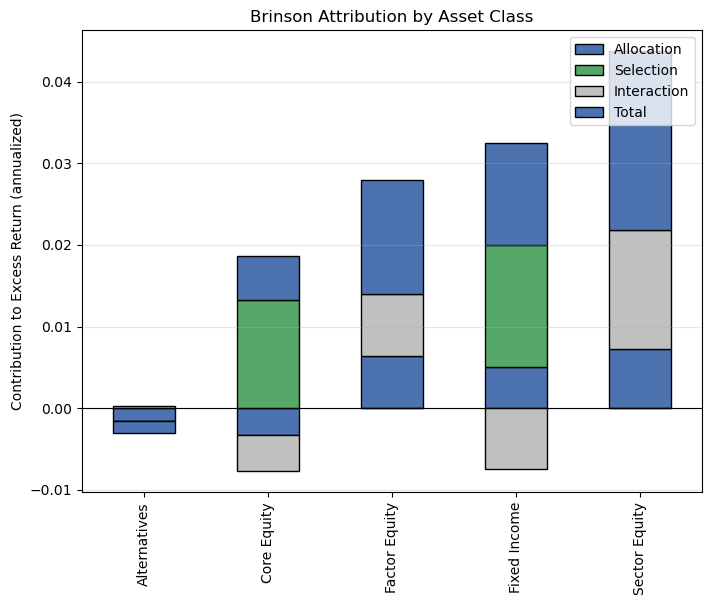

In [408]:
# --- SANITY CHECKS FOR BRINSON ATTRIBUTION ---

# 1. Portfolio and Benchmark total returns (annualized)
R_P = (w_p_classes * r_p_classes).sum()
R_B = (w_b_classes * r_b_classes).sum()
active_return = R_P - R_B

# 2. Sum of all Brinson effects
brinson_sum = (allocation + selection + interaction).sum()

# 3. Detailed display
print("=== Annualized Returns ===")
print(f"Portfolio return:  {R_P:.4%}")
print(f"Benchmark return:  {R_B:.4%}")
print(f"Active return:     {active_return:.4%}")
print()
print("=== Attribution Consistency ===")
print(f"Attribution sum:   {brinson_sum:.4%}")
print(f"Difference:        {(active_return - brinson_sum):.6e}")

# 4. Weight sanity checks
print("\n=== Weight Sums ===")
print(f"Sum portfolio weights: {w_p_classes.sum():.4f}")
print(f"Sum benchmark weights: {w_b_classes.sum():.4f}")

# 5. Optional: Table summary
summary = pd.DataFrame({
    "Portfolio Weight": w_p_classes,
    "Benchmark Weight": w_b_classes,
    "Portfolio Return": r_p_classes,
    "Benchmark Return": r_b_classes,
    "Allocation": allocation,
    "Selection": selection,
    "Interaction": interaction,
    "Total Effect": allocation + selection + interaction
})
display(summary)

# --- Visualization ---
brinson_df.drop("Total").plot(
    kind="bar", stacked=True, figsize=(8,6),
    color=["#4c72b0", "#55a868", "#c0c0c0"], edgecolor="black"
)
plt.title("Brinson Attribution by Asset Class")
plt.ylabel("Contribution to Excess Return (annualized)")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend(loc="upper right")
plt.grid(axis="y", alpha=0.3)
plt.show()

### 2. Visual Summary

The stacked bar chart below illustrates the contribution of each effect to the total active return by asset class.

- 🟦 Allocation – structural weighting decisions
- 🟩 Selection – security choice within classes
- ⬜ Interaction – overlap between allocation & selection

Overall, the strongest sources of value added are Sector Equity, Factor Equity and Fixed Income, while Alternatives slightly detracted.

### 3. Executive Interpretation

The optimized portfolio achieved an active return of +5.24% versus the benchmark.

- Performance was driven mainly by stock selection (notably in Core Equity and Fixed Income) and strategic overweighting in outperforming asset classes.
- The Alternatives segment was the only negative contributor, due to a small underweight position.
- The interaction term confirms consistent synergy between allocation and selection — a hallmark of disciplined optimization.

## 11 Fama–French 3-Factor Analysis

## 1. Theoretical Background

The **Fama and French (1993)** model extends the traditional **CAPM** by introducing **three systematic risk factors** to explain the expected returns of financial assets:

$$
R_{it} - R_{ft} = \alpha_i + \beta_{i,M} (R_{Mt} - R_{ft}) + \beta_{i,SMB} \, SMB_t + \beta_{i,HML} \, HML_t + \varepsilon_{it}
$$

---

### **Where:**

- **Excess return** of asset or portfolio *i* over the risk-free rate. $$R_{it} - R_{ft}$$  
- **Excess return of the market** (*market risk premium*).  $$R_{Mt} - R_{ft}$$
- **SMB (Small Minus Big)**: **Size premium**, capturing the return difference between small-cap and large-cap stocks.  
- **HML (High Minus Low)**: **Value premium**, capturing the return difference between high book-to-market (value) and low book-to-market (growth) firms.  
- **Alpha**, the unexplained component of return (manager skill or market inefficiency).  $$\alpha_i$$
- **Factor loadings** or **sensitivities** of the asset/portfolio to each risk factor.  
$$\beta_{i,M}, \, \beta_{i,SMB}, \, \beta_{i,HML}$$ 
---

### **Interpretation Goal**

In this analysis, we **estimate the exposure coefficients (betas)** and **alphas** for both the **optimized portfolio** and the **60/40 benchmark**, aiming to determine whether the optimized portfolio generates **abnormal returns not explained by systematic risk factors**.


In [409]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# Descargar factores Fama-French
ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start, end)[0]

# Convertir PeriodIndex a DatetimeIndex (último día de cada mes)
ff.index = ff.index.to_timestamp("M")

# Pasar de % a decimales
ff = ff / 100

print(ff.head())

            Mkt-RF     SMB     HML      RF
Date                                      
2000-01-31 -0.0474  0.0516 -0.0112  0.0041
2000-02-29  0.0246  0.2125 -0.0977  0.0043
2000-03-31  0.0521 -0.1741  0.0850  0.0047
2000-04-30 -0.0639 -0.0600  0.0645  0.0046
2000-05-31 -0.0439 -0.0608  0.0459  0.0050


/var/folders/st/ghz8l08945n3p0sn_hkwwrmw0000gn/T/ipykernel_6248/2672405565.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start, end)[0]
/var/folders/st/ghz8l08945n3p0sn_hkwwrmw0000gn/T/ipykernel_6248/2672405565.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start, end)[0]


In [410]:
import statsmodels.api as sm

# === 1. Calcular retornos mensuales de tus activos ===
asset_returns = adj_close_df[tickers] \
                    .resample("M").last().pct_change().dropna()

In [411]:
import statsmodels.api as sm

# === 1. Calcular retornos de cada cartera (mensuales) ===
# Benchmark 60/40
ret_6040 = (asset_returns * weights_6040).sum(axis=1)

# Portafolio óptimo
ret_opt = (asset_returns * w_opt).sum(axis=1)

# === 2. Alinear con factores ===
data = pd.DataFrame({
    "6040": ret_6040,
    "Optimal": ret_opt
}).join(ff, how="inner")

# === 3. Función de regresión Fama-French 3F (para una cartera) ===
def fama_french_regression(portfolio, factors=data[["Mkt-RF","SMB","HML"]], rf=data["RF"]):
    y = data[portfolio] - rf               # exceso de retorno de la cartera
    X = sm.add_constant(factors)           # factores + alpha
    model = sm.OLS(y, X).fit()
    return model

# === 4. Aplicar a las dos carteras ===
results = {}
for port in ["6040", "Optimal"]:
    model = fama_french_regression(port)
    results[port] = model.params
    print(f"\n📊 {port} Fama-French 3F Regression")
    print(model.summary())

# === 5. Tabla consolidada ===
betas_df = pd.DataFrame(results).T
betas_df = betas_df.rename(columns={
    "const": "Alpha",
    "Mkt-RF": "Beta_Market",
    "SMB": "Beta_SMB",
    "HML": "Beta_HML"
})

print("\n✅ Exposiciones Fama-French (3F) para carteras:")
print(betas_df.round(3))



📊 6040 Fama-French 3F Regression
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     39.77
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.16e-17
Time:                        11:39:31   Log-Likelihood:                 268.31
No. Observations:                 118   AIC:                            -528.6
Df Residuals:                     114   BIC:                            -517.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0

In [412]:
# === 5. Consolidar resultados en una tabla ===
betas_df = pd.DataFrame(results).T
betas_df = betas_df.rename(columns={
    "const": "Alpha",
    "Mkt-RF": "Beta_Market",
    "SMB": "Beta_SMB",
    "HML": "Beta_HML"
})

print("\n✅ Exposiciones Fama-French (3F):")
print(betas_df.round(3))


✅ Exposiciones Fama-French (3F):
         Alpha  Beta_Market  Beta_SMB  Beta_HML
6040    -0.003        0.563    -0.033     0.039
Optimal  0.000        0.808    -0.114    -0.085


=== 🧪 SANITY CHECK: INPUT STRUCTURE ===
Asset returns freq: <MonthEnd>
FF factors freq: <MonthEnd>
Overlap period: 2015-11-30 → 2025-08-31
Missing values:
6040       0
Optimal    0
Mkt-RF     0
SMB        0
HML        0
RF         0
dtype: int64

✅ Monthly frequency confirmed.

=== 💹 RETURN CONSISTENCY ===
Mean monthly returns (6040 / Optimal):
6040       0.0047
Optimal    0.0105
dtype: float64

Annualized returns (approx):
6040       0.057
Optimal    0.126
dtype: float64

Standard deviations (monthly):
6040       0.0358
Optimal    0.0369
dtype: float64
✅ Optimal portfolio has higher mean return — consistent with expectation.

=== 🧮 FACTOR LEVELS ===
        Mkt-RF      SMB      HML       RF
count  308.000  308.000  308.000  308.000
mean     0.006    0.001    0.002    0.002
std      0.046    0.032    0.035    0.002
min     -0.172   -0.174   -0.138    0.000
25%     -0.020   -0.019   -0.016    0.000
50%      0.012    0.001   -0.001    0.001
75%      0.033    0.018    0.017    0.003
max  

,Mkt-RF,SMB,HML
Mkt-RF,1.00,0.27,-0.03
SMB,0.27,1.00,-0.14
HML,-0.03,-0.14,1.00


⚠️ High collinearity detected among factors (>0.8).
=== 💰 EXCESS RETURN CHECK ===
Mean excess return (Optimal): 0.0088
✅ Portfolio delivers positive excess return.

=== 🧭 REGRESSION PARAMETER SANITY ===
         Alpha  Beta_Market  Beta_SMB  Beta_HML
6040    -0.003        0.563    -0.033     0.039
Optimal  0.000        0.808    -0.114    -0.085

6040 portfolio:
✅ Alpha magnitude plausible.
✅ Market beta within normal range.

Optimal portfolio:
✅ Alpha magnitude plausible.
✅ Market beta within normal range.

=== 🧾 RESIDUAL DIAGNOSTICS (Optimal) ===
Durbin–Watson statistic: 2.18
✅ Residuals show no strong autocorrelation.
Shapiro–Wilk p-value: 0.565
✅ Residuals approximately normal.


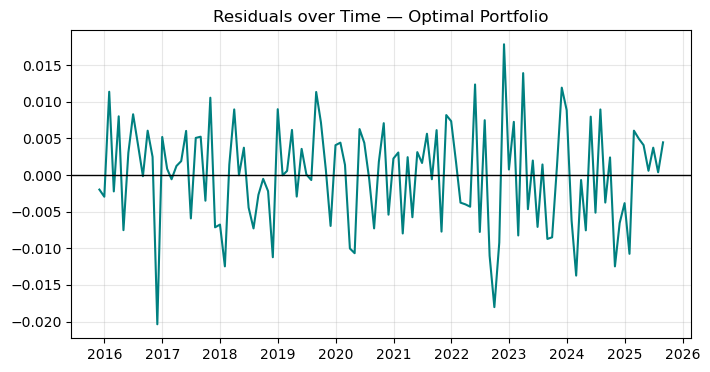


=== 🧮 PORTFOLIO COMPARISON SUMMARY ===


,Alpha_diff,Beta_Market_diff,Beta_SMB_diff,Beta_HML_diff
0,0.003,0.244,-0.081,-0.124


✅ Consistency check complete. Review warnings above if present.


In [413]:
# =============================================
# 🔍 FAMA-FRENCH 3F MODEL — FULL SANITY CHECK SUITE
# =============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

print("=== 🧪 SANITY CHECK: INPUT STRUCTURE ===")
print(f"Asset returns freq: {asset_returns.index.freq}")
print(f"FF factors freq: {ff.index.freq}")
print(f"Overlap period: {data.index.min().date()} → {data.index.max().date()}")
print(f"Missing values:\n{data.isna().sum()}\n")

# ✅ Check frequency and overlapping
if (asset_returns.index.freqstr != 'M') or (ff.index.freqstr != 'M'):
    print("⚠️ WARNING: Frequency mismatch — ensure both are monthly.")
else:
    print("✅ Monthly frequency confirmed.\n")

# =============================================
# CHECK 2: RETURN MAGNITUDES
# =============================================
print("=== 💹 RETURN CONSISTENCY ===")
print("Mean monthly returns (6040 / Optimal):")
print(data[["6040", "Optimal"]].mean().round(4))
print("\nAnnualized returns (approx):")
print((data[["6040", "Optimal"]].mean() * 12).round(3))
print("\nStandard deviations (monthly):")
print(data[["6040", "Optimal"]].std().round(4))

if data["Optimal"].mean() < data["6040"].mean():
    print("⚠️ Optimal portfolio has lower mean return than 60/40 — check optimization logic.\n")
else:
    print("✅ Optimal portfolio has higher mean return — consistent with expectation.\n")

# =============================================
# CHECK 3: FACTOR MAGNITUDES & ALIGNMENT
# =============================================
print("=== 🧮 FACTOR LEVELS ===")
print(ff.describe().round(3))
print("\nAverage annualized market return (Mkt-RF + RF):",
      round((ff["Mkt-RF"] + ff["RF"]).mean() * 12, 3))

# Check if factors roughly in expected range
if abs(ff["Mkt-RF"].mean()) > 0.02:
    print("⚠️ Mkt-RF seems too high — check scaling (divide by 100 if missing).")
else:
    print("✅ Factor magnitudes look normal (monthly % converted to decimals).\n")

# =============================================
# CHECK 4: MULTICOLLINEARITY AMONG FACTORS
# =============================================
print("=== 📈 FACTOR CORRELATIONS ===")
corr = ff[["Mkt-RF", "SMB", "HML"]].corr().round(2)
display(corr)

if (corr.abs() > 0.8).any().any():
    print("⚠️ High collinearity detected among factors (>0.8).")
else:
    print("✅ No severe multicollinearity — regression stability acceptable.\n")

# =============================================
# CHECK 5: EXCESS RETURN VERIFICATION
# =============================================
print("=== 💰 EXCESS RETURN CHECK ===")
y_opt = data["Optimal"] - data["RF"]
print(f"Mean excess return (Optimal): {y_opt.mean():.4f}")
if y_opt.mean() <= 0:
    print("⚠️ Portfolio underperforms risk-free rate — unexpected for long horizon.")
else:
    print("✅ Portfolio delivers positive excess return.\n")

# =============================================
# CHECK 6: REGRESSION OUTPUTS VALIDATION
# =============================================
print("=== 🧭 REGRESSION PARAMETER SANITY ===")
print(betas_df.round(3))

# Parameter expectations
for port in betas_df.index:
    alpha = betas_df.loc[port, "Alpha"]
    beta_mkt = betas_df.loc[port, "Beta_Market"]
    print(f"\n{port} portfolio:")
    if abs(alpha) > 0.01:
        print("⚠️ Alpha unusually large — check scaling (monthly alpha > 1%).")
    else:
        print("✅ Alpha magnitude plausible.")
    if not 0.5 < beta_mkt < 1.5:
        print(f"⚠️ Market beta ({beta_mkt:.2f}) outside expected range (0.5–1.5).")
    else:
        print("✅ Market beta within normal range.")

# =============================================
# CHECK 7: RESIDUAL DIAGNOSTICS
# =============================================
print("\n=== 🧾 RESIDUAL DIAGNOSTICS (Optimal) ===")
model_opt = fama_french_regression("Optimal")
resid = model_opt.resid

# Durbin-Watson
dw = sm.stats.durbin_watson(resid)
print(f"Durbin–Watson statistic: {dw:.2f}")
if dw < 1.5 or dw > 2.5:
    print("⚠️ Autocorrelation detected — consider Newey–West robust errors.")
else:
    print("✅ Residuals show no strong autocorrelation.")

# Normality test
shapiro = stats.shapiro(resid)
print(f"Shapiro–Wilk p-value: {shapiro.pvalue:.3f}")
if shapiro.pvalue < 0.05:
    print("⚠️ Residuals deviate from normality (p < 0.05).")
else:
    print("✅ Residuals approximately normal.")

# =============================================
# CHECK 8: RESIDUAL PLOT
# =============================================
plt.figure(figsize=(8,4))
plt.plot(resid, color='teal')
plt.axhline(0, color='black', lw=1)
plt.title("Residuals over Time — Optimal Portfolio")
plt.grid(alpha=0.3)
plt.show()

# =============================================
# CHECK 9: PORTFOLIO COMPARISON SUMMARY
# =============================================
print("\n=== 🧮 PORTFOLIO COMPARISON SUMMARY ===")
comparison = pd.DataFrame({
    "Alpha_diff": [betas_df.loc["Optimal","Alpha"] - betas_df.loc["6040","Alpha"]],
    "Beta_Market_diff": [betas_df.loc["Optimal","Beta_Market"] - betas_df.loc["6040","Beta_Market"]],
    "Beta_SMB_diff": [betas_df.loc["Optimal","Beta_SMB"] - betas_df.loc["6040","Beta_SMB"]],
    "Beta_HML_diff": [betas_df.loc["Optimal","Beta_HML"] - betas_df.loc["6040","Beta_HML"]],
})
display(comparison.round(3))

print("✅ Consistency check complete. Review warnings above if present.")


### 3 Fs all Stocks 

In [414]:

# === 5. Consolidar resultados en una tabla ===
betas_df = pd.DataFrame(results).T
betas_df = betas_df.rename(columns={
    "const": "Alpha",
    "Mkt-RF": "Beta_Market",
    "SMB": "Beta_SMB",
    "HML": "Beta_HML"
})

print("\n✅ Exposiciones Fama-French (3F):")
print(betas_df.round(3))# === 2. Alinear con los factores ===
data = asset_returns.join(ff, how="inner")

# === 3. Función para correr la regresión Fama-French 3F ===
def fama_french_regression(asset, factors=data[["Mkt-RF","SMB","HML"]], rf=data["RF"]):
    # exceso de retorno del activo
    y = data[asset] - rf
    X = sm.add_constant(factors)   # añade intercepto (alpha)
    model = sm.OLS(y, X).fit()
    return model

# === 4. Aplicar a tus 5 ETFs ===
results = {}
for ticker in tickers:
    model = fama_french_regression(ticker)
    results[ticker] = model.params  # guardar coeficientes
    print(f"\n📊 {ticker} Fama-French 3F Regression")
    print(model.summary())


✅ Exposiciones Fama-French (3F):
         Alpha  Beta_Market  Beta_SMB  Beta_HML
6040    -0.003        0.563    -0.033     0.039
Optimal  0.000        0.808    -0.114    -0.085

📊 SPY Fama-French 3F Regression
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     34.24
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           7.45e-16
Time:                        11:39:33   Log-Likelihood:                 228.63
No. Observations:                 118   AIC:                            -449.3
Df Residuals:                     114   BIC:                            -438.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         